# OC - Parcours Ingénieur IA - Projet Olist - BERKAN Asli Ceren
# Partie II : Essais des différentes approches de modélisation 

Le projet 5 (ou projet Olist) effectué dans le cadre de la formation en ingénieur IA a pour but de segmenter les clients d'une solution de vente sur les marketplaces en ligne (Olist).

Les équipes d'e-commerce pourront utiliser la segmentation des clients au quotidien pour leurs compagnes de communication. Ainsi, on peut comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs données personnelles. Pour ce faire, on doit fournir une description actionnable de la segmentation et une proposition de contrat de maintenance basée sur l'analyse de la stabilité des segments au cours du temps.

La base de données est fournie par Olist. On doit donc utiliser des méthodes non supervisées pour regrouper l'ensemble des clients de profils similaires.

## Table of Contents

* [1. Analyse RFM](#chapter1)
     * [1.1. Préparation des données](#section_1_1)
     * [1.2. Avec 4 clusters](#section_1_2)
* [2. Kmeans](#chapter2)
    * [2.1. Kmeans avec les données de RFM](#section_2_1)
    * [2.2. Kmeans avec les données de RFM et quelques features clés](#section_2_2)
    * [2.3. Les données après EDA, PCA et Kmeans](#section_2_3)
* [3. DBSCAN](#chapter3)
    * [3.1. PCA 2 + DBSCAN](#section_3_1)
    * [3.2. PCA 3 + DBSCAN](#section_3_2)
    * [3.3. Optimisation des paramètres pour DBSCAN (2d)](#section_3_3)
    * [3.4. Optimisation des paramètres pour DBSCAN (3d)](#section_3_4)
    * [3.5. Comparatif des modèles](#section_3_5) 
* [4. Clustering hiérarchique](#chapter4)
* [5. Choix du modèle et observations](#chapter5)
    * [5.1. Modèle final](#section_5_1)
    * [5.2. Modèle final amélioré](#section_5_2)
* [6. Contrat de maintenance & Ajout de nouveau client](#chapter6)

In [3]:
#%load_ext pycodestyle_magic

In [4]:
#%pycodestyle_on

In [5]:
#pip install yellowbrick

In [165]:
import pandas as pd  # pour importer les données sous formes de dataframe
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dill  # Enregistrer une session Notebook
import mpl_toolkits.mplot3d.axes3d as p3
import math

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from matplotlib.ticker import MaxNLocator

In [7]:
# Restaurer la session notebook
dill.load_session('notebook_env_0809_entier.db')

In [8]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha, s=3)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value, s=3)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            #plt.xlim([-boundary,boundary])
            #plt.ylim([-boundary,boundary])
            plt.xlim([-5,50])
            plt.ylim([-10,10])
            
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)


def display_factorial_planes2(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha, s=3)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value, s=3)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
            #plt.xlim([-5,50])
            #plt.ylim([-10,10])
            
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)

In [9]:
forme_cluster = pd.DataFrame(columns=['Modèle',
                                      'Silhouette',
                                      'Davies Bouldin'])


def calc_metrics(nom_modele, X, labels, forme_cluster):
    '''Calcul des métriques de forme pour les clusters
    (Silhouette et Davies Bouldin)
    '''
    if not forme_cluster.empty :
        # Vérifier si la dernière ligne est identique
        df2 = forme_cluster.iloc[-1]
        if df2["Modèle"] == nom_modele :
            forme_cluster.drop(forme_cluster.tail(1).index, inplace=True) 
        
    silh_score = metrics.silhouette_score(X, labels)
    davi_score = metrics.davies_bouldin_score(X, labels)
    forme_cluster = forme_cluster.append({'Modèle' : nom_modele,
                                          'Silhouette' : silh_score,
                                          'Davies Bouldin' : davi_score},
                                          ignore_index=True)
    return forme_cluster


stabilite_cluster = pd.DataFrame(columns=['Modèle 1', 'Modèle 2', 'ARI'])


def calc_ari(nom_modele_1, nom_modele_2, labels_true, labels_pred, stabilite_cluster):
    '''Calcul du métrique de stabilité pour les clusters
    (Adjusted Rand Index)
    '''
    if not stabilite_cluster.empty :
        #Vérifier si la dernière ligne est identique à celle que l'on souhaite écrire
        df2 = stabilite_cluster.iloc[-1]
        if df2["Modèle 1"] == nom_modele_1:
            if df2["Modèle 2"] == nom_modele_2:
                stabilite_cluster.drop(stabilite_cluster.tail(1).index, inplace=True)
            
    ari_score = metrics.adjusted_rand_score(labels_true, labels_pred)
    
    stabilite_cluster = stabilite_cluster.append({'Modèle 1' : nom_modele_1, 
                                                  'Modèle 2' : nom_modele_2,
                                                  'ARI' : ari_score}, 
                                                   ignore_index=True)
    return stabilite_cluster

In [10]:
# Pour la segmentation

# Plus le recency est faible et plus le client est fidèle
def RScoring(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else :
        return 4

# A l'inverse plus la fréquence (ou le monetary) est élevée et plus le client est fidèle
def FnMScoring(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else :
        return 1
    
def pltGroupLoy(RFM, loyalty_level, i, titre):
    groupRFM = RFM[RFM['RFMLoyaltyLevel'] == loyalty_level[i]]

    # Affichage recency
    fig, (ax1, ax2)  = plt.subplots(1, 2)
    fig.suptitle(titre)
    sns.histplot(ax=ax1, x=RFM['recency'])
    sns.histplot(ax=ax2, x=groupRFM['recency'])
    ax1.axis(ymin=0, ymax=0.006, xmin=-100, xmax=800)
    ax2.axis(ymin=0, ymax=0.006, xmin=-100, xmax=800)
    
def pltGroupLoyFreq(RFM, loyalty_level, i, titre):
    groupRFM = RFM[RFM['RFMLoyaltyLevel'] == loyalty_level[i]]

    # Affichage frequency or monetary
    fig, (ax1, ax2)  = plt.subplots(1, 2)
    fig.suptitle(titre)
    sns.histplot(ax=ax1, x=RFM.query('frequency<5')['frequency'])
    sns.histplot(ax=ax2, x=groupRFM.query('frequency<5')['frequency'])
    ax1.axis(ymin=0, ymax=60, xmin=-1, xmax=5)
    ax2.axis(ymin=0, ymax=60, xmin=-1, xmax=5)

In [11]:
def plot_dbscan_2d(db, X):
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()


def plot_dbscan_3d(db, X):
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]

    fig = plt.figure()
    ax = p3.Axes3D(fig)

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        ax.plot(xy[:, 0], xy[:, 1], xy[:, 2], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        ax.plot(xy[:, 0], xy[:, 1], xy[:, 2], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()


def set_parameter_dbscan(EPS, MinSamples, X) :
    Cluster = pd.DataFrame(columns=['n_clus', 'n_noise', 'eps', 'min_sample'])

    for i in EPS :
        for j in MinSamples :
            db = DBSCAN(eps=i, min_samples=j, metric='euclidean')
            db.fit(X)
            labels = db.labels_

            # Number of clusters in labels, ignoring noise if present.
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)

            # Append 
            Cluster = Cluster.append({'n_clus' : n_clusters_ , 'n_noise' : n_noise_, 
                                      'eps' : i, 'min_sample' : j}, 
                                      ignore_index=True)
    return Cluster


def calc_dbscan(eps_opt, min_sample_opt, X) :
    db_opt = DBSCAN(eps=eps_opt, min_samples=min_sample_opt, metric='euclidean')
    db_opt.fit(X)
    y_df_DBSCAN_opt = db_opt.fit_predict(X)

    # Affichage
    core_samples_mask_opt = np.zeros_like(db_opt.labels_, dtype=bool)
    core_samples_mask_opt[db_opt.core_sample_indices_] = True
    labels_opt = db_opt.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_opt = len(set(labels_opt)) - (1 if -1 in labels else 0)
    n_noise_opt = list(labels_opt).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_opt)
    print('Estimated number of noise points: %d' % n_noise_opt)
    return db_opt

In [12]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


def plot_scatter(X,  color, alpha=0.5):
    return plt.scatter(X[:, 0],
                       X[:, 1],
                       c=color,
                       alpha=alpha,
                       edgecolor='k')

In [13]:
# Fonction pour l'affichage des infos par cluster
def plot_clus(cluster, variable_etudie, X):
    moy_score = X[[cluster, variable_etudie]]\
                .groupby([cluster], as_index=False).mean()
    
    tot_score = X[[cluster, variable_etudie]]\
                .groupby([cluster], as_index=False).sum()
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    s = sns.barplot(ax=ax1, x=cluster, y=variable_etudie,
                order=moy_score[cluster], data=moy_score,
                palette='cubehelix')
    ax1.title.set_text('Moyenne')
    s = sns.barplot(ax=ax2, x=cluster, y=variable_etudie,
                order=moy_score[cluster], data=tot_score,
                palette='cubehelix')
    ax2.title.set_text('Total')
    
    plt.show()

Les données sont d'abord chargées dans l'environnement de travail. On va ensuite observer quelques caractéristiques du jeu de données et vérifier les données dupliquées.

In [14]:
#from google.colab import drive
#drive.mount('/content/drive')

In [15]:
df = pd.read_csv("olist_customers_clustering.csv", index_col=0)
df.order_purchase_timestamp = pd.to_datetime(
    df.order_purchase_timestamp)
#df = pd.read_csv("/content/drive/MyDrive/0_OC_ParcoursIA/Projet5/olist_customers_clustering.csv", index_col=0)

In [16]:
# Affichage
display(df.sort_values('customer_unique_id', ascending=False).head())

,order_purchase_timestamp,customer_zip_code_prefix,delivery_delta_days,nb_payment_sequential,sum_payment_installments,is_reviewed,review_score,mean_nb_items,nb_orders,sum_price,...,product_category_books_cds_media,product_category_fashion_clothing_accessories,product_category_flowers_gifts,product_category_groceries_food_drink,product_category_health_beauty,product_category_home_furniture,product_category_other,product_category_sport,product_category_technology,product_category_toys_baby
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
ffffd2657e2aad2907e67c3e9daecbeb,2017-05-02 20:18:45,83608,8,1,4,1,5,1.0,1,56.99,...,0,0,0,0,1,0,0,0,0,0
ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,29460,12,1,5,1,5,1.0,1,115.00,...,0,0,1,0,0,0,0,0,0,0
ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,78552,15,1,1,1,5,1.0,1,89.90,...,0,0,0,0,0,0,1,0,0,0
fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,44054,30,1,1,1,4,1.0,1,64.89,...,0,0,0,0,0,0,0,0,0,1
fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,55250,28,2,20,2,5,2.0,1,1570.00,...,0,0,0,0,1,0,0,0,0,0


In [17]:
#df = pd.read_csv("/content/drive/MyDrive/0_OC_ParcoursIA/Projet5/olist_customers_clustering.csv",index_col=0)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113382 entries, 871766c5855e863f6eccc05f988b23cb to cd76a00d8e3ca5e6ab9ed9ecb6667ac4
Data columns (total 27 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   order_purchase_timestamp                       113382 non-null  datetime64[ns]
 1   customer_zip_code_prefix                       113382 non-null  int64         
 2   delivery_delta_days                            113382 non-null  int64         
 3   nb_payment_sequential                          113382 non-null  int64         
 4   sum_payment_installments                       113382 non-null  int64         
 5   is_reviewed                                    113382 non-null  int64         
 6   review_score                                   113382 non-null  int64         
 7   mean_nb_items                                  113382 non-null  float64     

In [19]:
print('Le nombre de valeur unique :')
print(df.nunique())

Le nombre de valeur unique :
order_purchase_timestamp                         94620
customer_zip_code_prefix                         14844
delivery_delta_days                                143
nb_payment_sequential                               24
sum_payment_installments                            56
is_reviewed                                         24
review_score                                         5
mean_nb_items                                       51
nb_orders                                            9
sum_price                                         8528
sum_freight                                       8487
sum_payment                                      29847
recency                                            551
payment_type_boleto                                  2
payment_type_credit_card                             2
payment_type_debit_card                              2
payment_type_voucher                                 2
product_category_books_cds_media    

In [20]:
# Les valeurs dupliquées
test = df.copy()
test = test.reset_index()
dataNSdupp = test.duplicated(keep=False)
print("Nombre de lignés dupliquées :")
sum(bool(x) for x in dataNSdupp)

Nombre de lignés dupliquées :


26077

In [21]:
# Supprimer les doublons
df.drop_duplicates(inplace=True)

## 1. Analyse RFM <a class="anchor" id="chapter1"></a>

Une première méthode de segmentation que l'on va utiliser sur nos données est la segmentation RFM. Elle consiste à segmenter les clients en fonction de leur comportement d'achat. C'est une segmentation 100% comportementale. On ne segmente pas les clients en fonction de ce qu'ils sont (genre, sexe, ville, CSP…), ni en fonction de ce qu'ils aiment (centres d'intérêt, goûts), mais en fonction de ce qu'ils achètent. Le principe sous-jacent est simple : un client qui a acheté récemment, qui achète fréquemment et qui génère beaucoup de chiffre d'affaires commandera à nouveau, à coup quasiment sûr. Les chances de se tromper sont très faibles. La segmentation RFM repose sur ces 3 critères : Récence / Fréquence / Montant.
- La Récence : Combien de temps s'est-il écoulé depuis la dernière activité du client ?
- La Fréquence : Au cours d'une période de temps donnée, combien de fois un client a-t-il acheté ou interagi avec la marque ?
- Le Montant : Combien un client a-t-il dépensé d'argent au cours d'une période de temps donnée ?

### 1.1. Préparation des données <a class="anchor" id="section_1_1"></a>

In [22]:
# RFM
RFM = df[['recency', 'nb_orders', 'sum_payment']]
RFM = RFM.rename(columns={'nb_orders': 'frequency',
                          'sum_payment': 'monetary'})
display(RFM.sort_values('monetary', ascending=False).head())

,recency,frequency,monetary
customer_unique_id,,,
0a0a92112bd4c708ca5fde585afaa872,337,1,109312.64
698e1cf81d01a3d389d96145f7fa6df8,382,1,45256.00
c402f431464c72e27330a67f7b94d4fb,194,1,44048.00
4007669dec559734d6f53e029e360987,280,1,36489.24
ef8d54b3797ea4db1d63f0ced6a906e9,141,1,30186.00


In [23]:
# Vérification s'il y a des na
RFM.isna().sum()

recency      0
frequency    0
monetary     0
dtype: int64

In [24]:
# Statistiques descriptives
RFM.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
recency,97660.0,246.953338,152.127517,1.00,20.59,34.0,51.00,125.0,228.00,356.0,475.000,530.0000,586.0000,704.00
frequency,97660.0,1.074503,0.362202,1.00,1.00,1.0,1.00,1.0,1.00,1.0,1.000,2.0000,2.0000,14.00
monetary,97660.0,223.150228,670.310775,9.59,22.84,33.0,40.85,65.0,115.99,211.6,428.838,702.0705,1787.4368,109312.64


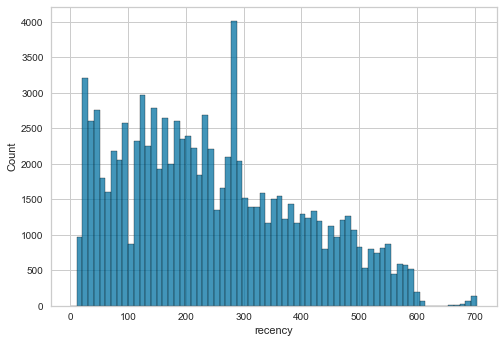

In [25]:
# Affichage recency
ax = sns.histplot(RFM['recency'])

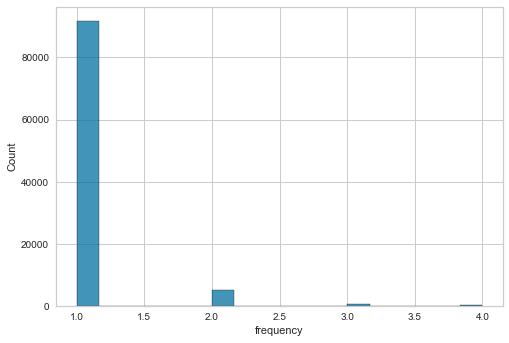

In [26]:
# Affichage frequency
ax = sns.histplot(RFM.query('frequency < 5')['frequency'])

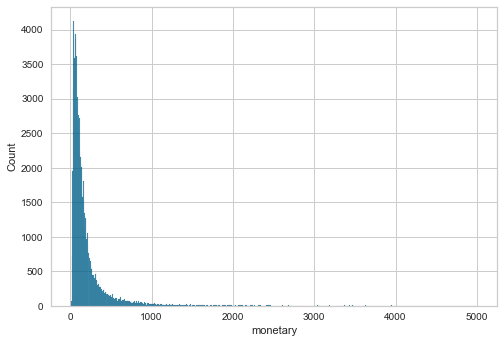

In [27]:
# Affichage monetary
ax = sns.histplot(RFM.query('monetary < 5000')['monetary'])

### 1.2. Avec 4 clusters <a class="anchor" id="section_1_2"></a>

Je décide d'effectuer une segmentation en 4 clusters des clients : Platinum, Gold, Silver et Bronze. Pour un ciblage marketing, c'est plus facile de présenter un faible nombre de clusters. Pour ce faire, on va accorder des scores pour chacun des trois valeurs RFM en fonction des quantiles 0.25, 0.5 et 0.75. Puis on va calculer un score global permettant de segmenter les clients. 

In [28]:
# Définition des quantiles
quantiles = RFM.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()
quantiles

{'recency': {0.25: 125.0, 0.5: 228.0, 0.75: 356.0},
 'frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'monetary': {0.25: 65.0, 0.5: 115.99000000000001, 0.75: 211.6}}

In [29]:
# Segmentation rfm
RFM['RecencyScore'] = RFM['recency'].apply(RScoring,
                                           args=('recency', quantiles))
RFM['FrequencyScore'] = RFM['frequency'].apply(FnMScoring,
                                               args=('frequency', quantiles))
RFM['MonetaryScore'] = RFM['monetary'].apply(FnMScoring,
                                             args=('monetary', quantiles))
RFM.head()

,recency,frequency,monetary,RecencyScore,FrequencyScore,MonetaryScore
customer_unique_id,,,,,,
871766c5855e863f6eccc05f988b23cb,358,1,72.19,4,4,3
eb28e67c4c0b83846050ddfb8a35d051,356,2,284.56,3,1,1
eb28e67c4c0b83846050ddfb8a35d051,356,2,284.56,3,1,1
3818d81c6709e39d06b2738a8d3a2474,239,1,216.87,3,4,1
af861d436cfc08b2c2ddefd0ba074622,33,1,25.78,1,4,4


In [30]:
# Calcul des scores
RFM['RFMGroup'] = RFM.RecencyScore.map(str)\
    + RFM.FrequencyScore.map(str)\
    + RFM.MonetaryScore.map(str)

RFM['RFMScore'] = RFM[['RecencyScore', 'FrequencyScore',
                       'MonetaryScore']].sum(axis=1)
RFM.head()

,recency,frequency,monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMGroup,RFMScore
customer_unique_id,,,,,,,,
871766c5855e863f6eccc05f988b23cb,358,1,72.19,4,4,3,443,11
eb28e67c4c0b83846050ddfb8a35d051,356,2,284.56,3,1,1,311,5
eb28e67c4c0b83846050ddfb8a35d051,356,2,284.56,3,1,1,311,5
3818d81c6709e39d06b2738a8d3a2474,239,1,216.87,3,4,1,341,8
af861d436cfc08b2c2ddefd0ba074622,33,1,25.78,1,4,4,144,9


In [31]:
# Regarder avec 4 catégories
loyalty_level = ['Platinum', 'Gold', 'Silver', 'Bronze']
score_cuts = pd.qcut(RFM.RFMScore, q=4, labels=loyalty_level)
RFM['RFMLoyaltyLevel'] = score_cuts.values
RFM.head()

,recency,frequency,monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMGroup,RFMScore,RFMLoyaltyLevel
customer_unique_id,,,,,,,,,
871766c5855e863f6eccc05f988b23cb,358,1,72.19,4,4,3,443,11,Bronze
eb28e67c4c0b83846050ddfb8a35d051,356,2,284.56,3,1,1,311,5,Platinum
eb28e67c4c0b83846050ddfb8a35d051,356,2,284.56,3,1,1,311,5,Platinum
3818d81c6709e39d06b2738a8d3a2474,239,1,216.87,3,4,1,341,8,Platinum
af861d436cfc08b2c2ddefd0ba074622,33,1,25.78,1,4,4,144,9,Gold


In [32]:
# Affichage des clients Platinum
RFM[RFM['RFMGroup'] == '111'].sort_values('monetary', ascending=False).head(10)

,recency,frequency,monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMGroup,RFMScore,RFMLoyaltyLevel
customer_unique_id,,,,,,,,,
c8460e4251689ba205045f3ea17884a1,29,4,27935.46,1,1,1,111,3,Platinum
c8460e4251689ba205045f3ea17884a1,29,4,27935.46,1,1,1,111,3,Platinum
c8460e4251689ba205045f3ea17884a1,29,4,27935.46,1,1,1,111,3,Platinum
c8460e4251689ba205045f3ea17884a1,29,4,27935.46,1,1,1,111,3,Platinum
906a8a4ec9f3d4c3e64fa6d1c4fe6009,51,2,11881.01,1,1,1,111,3,Platinum
906a8a4ec9f3d4c3e64fa6d1c4fe6009,51,2,11881.01,1,1,1,111,3,Platinum
1f98d2384ff7a372e6a2d3bb75cbcd54,99,2,6907.05,1,1,1,111,3,Platinum
1f98d2384ff7a372e6a2d3bb75cbcd54,99,2,6907.05,1,1,1,111,3,Platinum
0341bbd5c969923a0f801b9e2d10a7b8,105,2,5999.04,1,1,1,111,3,Platinum


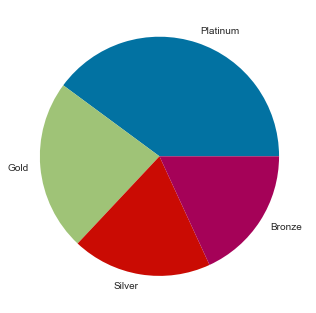

In [33]:
# Pourcentage de personnes par groupe
RFM['RFMLoyaltyLevel'].value_counts(normalize=True)*100
plt.pie(RFM['RFMLoyaltyLevel'].value_counts(normalize=True)*100,
        labels=loyalty_level)
plt.show()

,RFMLoyaltyLevel,RecencyMean,FrequencyMean,MonetaryMean,GroupSize
0,Platinum,151.081031,1.185709,370.629105,38948
1,Gold,241.235453,1.001904,203.962951,22582
2,Silver,303.142986,1.000000,93.838969,17701
3,Bronze,402.607087,1.000000,59.181396,18429


Text(0.5, 1.0, 'Monetary moyenne')

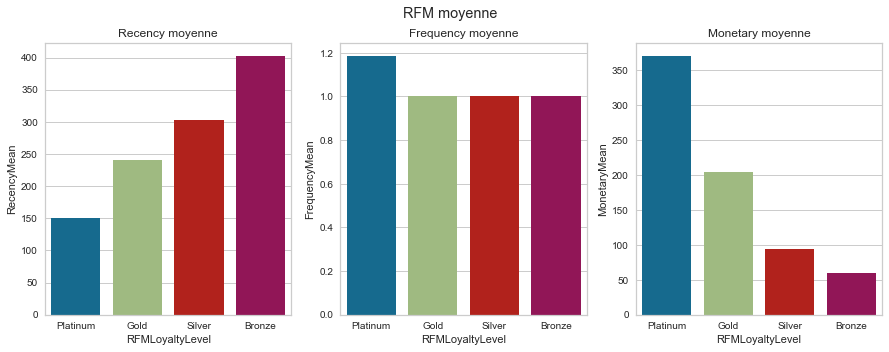

In [34]:
# Affichage des moyennes RFM
segmentwise = RFM.groupby('RFMLoyaltyLevel')\
    .agg(RecencyMean=('recency', 'mean'),
         FrequencyMean=('frequency', 'mean'),
         MonetaryMean=('monetary', 'mean'),
         GroupSize=('recency', 'size'))
segmentwise = segmentwise.reset_index()
display(segmentwise)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False)
fig.suptitle('RFM moyenne')

sns.barplot(ax=axes[0], x=segmentwise['RFMLoyaltyLevel'],
            y=segmentwise['RecencyMean'])
axes[0].set_title('Recency moyenne')
sns.barplot(ax=axes[1], x=segmentwise['RFMLoyaltyLevel'],
            y=segmentwise['FrequencyMean'])
axes[1].set_title('Frequency moyenne')
sns.barplot(ax=axes[2], x=segmentwise['RFMLoyaltyLevel'],
            y=segmentwise['MonetaryMean'])
axes[2].set_title('Monetary moyenne')

En moyenne, on observe bien les types de clients. En effet, pour la catégorie Platinum, le recency est faible, la fréquence est élevée et le monetary est élevé.

<AxesSubplot:xlabel='recency', ylabel='Count'>

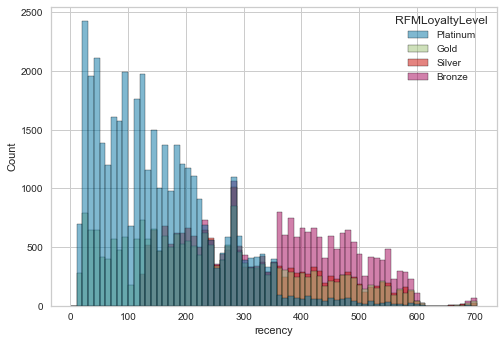

In [35]:
# Affichage recency
sns.histplot(data=RFM, x='recency', hue="RFMLoyaltyLevel")

<AxesSubplot:xlabel='frequency', ylabel='Count'>

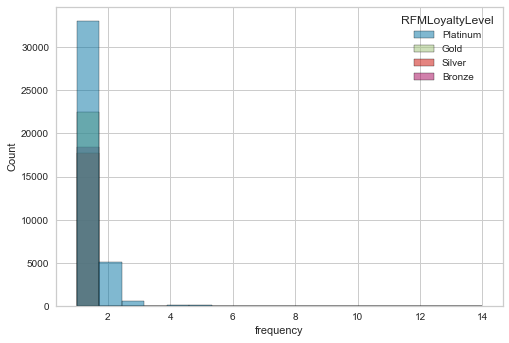

In [36]:
# Affichage frequency
sns.histplot(data=RFM, x='frequency', hue="RFMLoyaltyLevel")

Au niveau de la fréquence, on observe qu'uniquement le groupe Platinum présente des clients ayant effectué plus qu'une fois une opération d'achat. Les autres groupes, Gold, Silver et Bronze, présente des clients ayant effectué uniquement un achat.

In [37]:
# Affichage des métriques de forme de cluster : Silhouette score et Davies Bouldin score
forme_cluster = calc_metrics('RFM', RFM[['recency',
                                         'frequency',
                                         'monetary']],
                             RFM['RFMLoyaltyLevel'],
                             forme_cluster)

display(forme_cluster)

,Modèle,Silhouette,Davies Bouldin
0,RFM,-0.053926,2.589299


## 2. Kmeans <a class="anchor" id="chapter1"></a>

Le k-means est l'algorithme de clustering le plus simple. Il permet de réaliser des analyses non supervisées, de regrouper les individus ayant des caractéristiques similaires. C'est sûrement la méthode la plus connue et bien souvent quand on doit créer des groupes d'individus, on commence par le k-means. L'algorithme va chercher à créer des groupes d'individus homogènes :
- Des groupes dans lesquels les individus se ressemblent,
- Des groupes qui se distinguent le plus possible les uns des autres.
Pour ce faire, on tire aléatoirement n individus, n étant le nombre de clusters fixé. Ces n individus correspondent aux centres initiaux des n classes. On calcule la distance entre les individus et chaque centre. Plusieurs métriques existent pour définir la proximité entre 2 individus. On utilisera la méthode “classique” qui se base sur la distance euclidienne. On affecte chaque individu au centre le plus proche. On calcule les centres de gravité des groupes qui deviennent les nouveaux centres. On recommence ces étapes tant que les individus sont réaffectés à de nouveaux groupes après une itération. L'algorithme va converger vers une solution de clustering.

On va tester cet algorithme sur plusieurs jeux de données :
- RFM,
- RFM avec quelques features clés sélectionnés,
- Le jeu de données issu de l'analyse exploratoire et du nettoyage.

### 2.1. Kmeans avec les données de RFM <a class="anchor" id="section_2_1"></a>

In [38]:
# Les données
dataRFM = RFM[['RecencyScore', 'FrequencyScore', 'MonetaryScore']]
dataRFM.head()

,RecencyScore,FrequencyScore,MonetaryScore
customer_unique_id,,,
871766c5855e863f6eccc05f988b23cb,4,4,3
eb28e67c4c0b83846050ddfb8a35d051,3,1,1
eb28e67c4c0b83846050ddfb8a35d051,3,1,1
3818d81c6709e39d06b2738a8d3a2474,3,4,1
af861d436cfc08b2c2ddefd0ba074622,1,4,4


In [39]:
# Normalisation des données
cols = dataRFM.columns
X_rfm_kmeans = dataRFM.copy()
ms_rfm_kmeans = MinMaxScaler()
X_scaled_rfm_kmeans = ms_rfm_kmeans.fit_transform(X_rfm_kmeans)

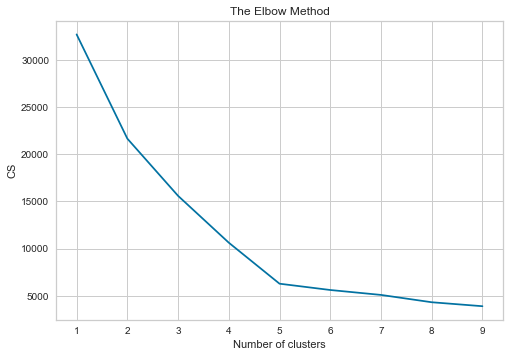

In [40]:
# Nombre de clusters qu'il faut choisir
cs_rfm_kmeans = []
for i in range(1, 10):
    RFM_kmeans = KMeans(n_clusters=i, init='random',
                        max_iter=300, n_init=10, random_state=0)
    RFM_kmeans.fit(X_scaled_rfm_kmeans)
    cs_rfm_kmeans.append(RFM_kmeans.inertia_)
plt.plot(range(1, 10), cs_rfm_kmeans)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

Le coude du graphe ci-dessus se trouve au niveau du nombre de clusters 5. Ainsi, on choisi un nombre de cluster égale à 5.

In [41]:
# 5 clusters
RFM_kmeans = KMeans(n_clusters=5, init='random',
                    max_iter=300, n_init=10, random_state=0)
RFM_kmeans.fit(X_scaled_rfm_kmeans)
y_kmeans_rfm_kmeans = RFM_kmeans.fit_predict(X_scaled_rfm_kmeans)
clusters_rfm_kmeans = RFM_kmeans.predict(X_scaled_rfm_kmeans)
RFM_kmeans.cluster_centers_

array([[1.64021644e-01, 1.00000000e+00, 1.76037605e-01],
       [8.34727152e-01, 1.00000000e+00, 8.33720883e-01],
       [8.32491933e-01, 1.00000000e+00, 1.72124188e-01],
       [4.51234568e-01, 2.33146835e-15, 1.81593715e-01],
       [1.67614521e-01, 1.00000000e+00, 8.37011572e-01]])

In [42]:
# L'inertie du modèle
RFM_kmeans.inertia_

6266.52128921305

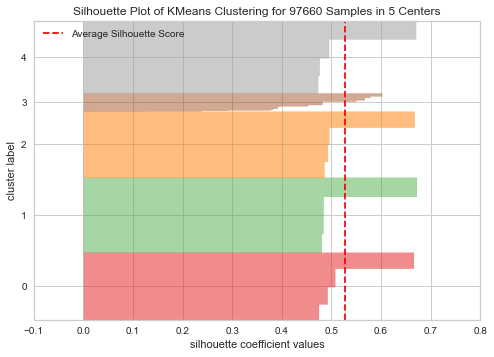

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 97660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [43]:
# Instantiate the clustering model and visualizer
visualizer_rfm_kmeans = SilhouetteVisualizer(RFM_kmeans)

# Fit the data to the visualizer
visualizer_rfm_kmeans.fit(X_scaled_rfm_kmeans)
visualizer_rfm_kmeans.poof()

Les clusters ne se chevauchent pas et sont bien distincts.

In [44]:
# Affichage des métriques de forme de cluster :
# Silhouette score et Davies Bouldin score
forme_cluster = calc_metrics('RFM Kmeans', X_scaled_rfm_kmeans,
                             RFM_kmeans.labels_, forme_cluster)

display(forme_cluster)

,Modèle,Silhouette,Davies Bouldin
0,RFM,-0.053926,2.589299
1,RFM Kmeans,0.528004,0.694183


In [45]:
# Affichage du métrique de stabilité : Ajusted Rand Index
stabilite_cluster = calc_ari('RFM', 'RFM Kmeans', RFM['RFMLoyaltyLevel'],
                             RFM_kmeans.labels_, stabilite_cluster)

display(stabilite_cluster)

,Modèle 1,Modèle 2,ARI
0,RFM,RFM Kmeans,0.374766


### 2.2. Kmeans avec les données de RFM et quelques features clés <a class="anchor" id="section_2_2"></a>

In [46]:
# Les données
dataRFMFeat = RFM[['RecencyScore', 'FrequencyScore', 'MonetaryScore']]
dataRFMFeat.insert(loc=len(dataRFMFeat.columns), column='review_score',
                   value=df['review_score'])
dataRFMFeat.insert(loc=len(dataRFMFeat.columns),
                   column='customer_zip_code_prefix',
                   value=df['customer_zip_code_prefix'])
dataRFMFeat.insert(loc=len(dataRFMFeat.columns),
                   column='delivery_delta_days',
                   value=df['delivery_delta_days'])
dataRFMFeat.head()

,RecencyScore,FrequencyScore,MonetaryScore,review_score,customer_zip_code_prefix,delivery_delta_days
customer_unique_id,,,,,,
871766c5855e863f6eccc05f988b23cb,4,4,3,5,28013,8
eb28e67c4c0b83846050ddfb8a35d051,3,1,1,4,15775,16
eb28e67c4c0b83846050ddfb8a35d051,3,1,1,5,15775,7
3818d81c6709e39d06b2738a8d3a2474,3,4,1,5,35661,8
af861d436cfc08b2c2ddefd0ba074622,1,4,4,4,12952,6


In [47]:
# Normalisation des données
colsFeat = dataRFMFeat.columns
X_feat = dataRFMFeat.copy()
ms_feat = MinMaxScaler()
X_feat_scaled = ms_feat.fit_transform(X_feat)

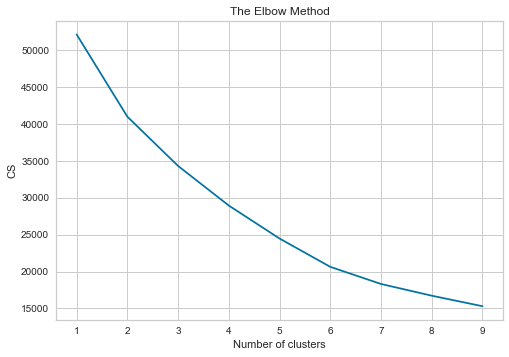

In [48]:
# Nombre de clusters qu'il faut choisir
cs_feat = []
for i in range(1, 10):
    kmeans_feat = KMeans(n_clusters=i, init='random',
                         max_iter=300, n_init=10, random_state=0)
    kmeans_feat.fit(X_feat_scaled)
    cs_feat.append(kmeans_feat.inertia_)
plt.plot(range(1, 10), cs_feat)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

Le coude est nettement moins marqué sur ce graphe. De ce fait, je décide de tester sur 5 et 6 clusters l'algorithme kmeans. Les métriques de formes pourront permettre de réaliser un choix entre ces deux modèles.

In [49]:
# 5 clusters
kmeans_feat = KMeans(n_clusters=5, init='random',
                     max_iter=300, n_init=10, random_state=0)
kmeans_feat.fit(X_feat_scaled)
y_feat_kmeans = kmeans_feat.fit_predict(X_feat_scaled)
clusters_feat = kmeans_feat.predict(X_feat_scaled)
kmeans_feat.cluster_centers_

array([[4.50864780e-01, 2.44249065e-15, 1.81042228e-01, 8.02307951e-01,
        3.33110211e-01, 5.39011014e-02],
       [2.37795178e-01, 1.00000000e+00, 1.49685709e-01, 9.11226428e-01,
        3.62389672e-01, 5.06470293e-02],
       [5.05596465e-01, 9.99705449e-01, 4.14089347e-01, 1.06885125e-01,
        3.64264122e-01, 9.05405501e-02],
       [2.45926044e-01, 1.00000000e+00, 8.67719382e-01, 8.94708509e-01,
        2.82336942e-01, 4.26920639e-02],
       [8.84318521e-01, 1.00000000e+00, 5.44632553e-01, 8.99683956e-01,
        3.78871286e-01, 5.27741333e-02]])

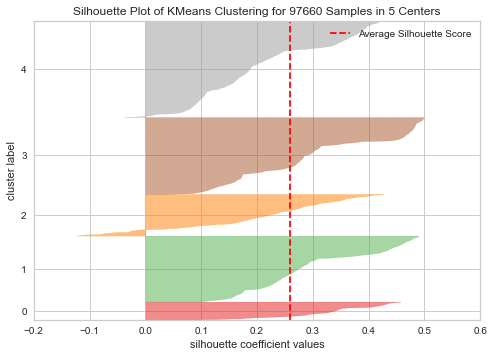

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 97660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [50]:
# Instantiate the clustering model and visualizer 
visualizer_feat = SilhouetteVisualizer(kmeans_feat)

# Fit the data to the visualizer
visualizer_feat.fit(X_feat_scaled)    
visualizer_feat.poof()  

Les clusters ne se chevauchent pas et sont bien distincts, mais quelques clients ont été mal classés. 

In [51]:
# Affichage des métriques de forme de cluster :
# Silhouette score et Davies Bouldin score
forme_cluster = calc_metrics('RFM Kmeans + feat 5', X_feat_scaled,
                             kmeans_feat.labels_, forme_cluster)

display(forme_cluster)

,Modèle,Silhouette,Davies Bouldin
0,RFM,-0.053926,2.589299
1,RFM Kmeans,0.528004,0.694183
2,RFM Kmeans + feat 5,0.259236,1.178834


In [52]:
# Affichage du métrique de stabilité : Ajusted Rand Index
stabilite_cluster = calc_ari('RFM Kmeans', 'RFM Kmeans + feat 5',
                             RFM_kmeans.labels_, kmeans_feat.labels_,
                             stabilite_cluster)

display(stabilite_cluster)

,Modèle 1,Modèle 2,ARI
0,RFM,RFM Kmeans,0.374766
1,RFM Kmeans,RFM Kmeans + feat 5,0.500833


In [53]:
# 6 clusters
kmeans_feat6 = KMeans(n_clusters=6, init='random',
                      max_iter=300, n_init=10, random_state=0)
kmeans_feat6.fit(X_feat_scaled)
y_feat_kmeans6 = kmeans_feat6.fit_predict(X_feat_scaled)
clusters_feat6 = kmeans_feat6.predict(X_feat_scaled)
kmeans_feat6.cluster_centers_

array([[1.61084530e-01, 1.00000000e+00, 8.39984051e-01, 8.94844498e-01,
        3.06242365e-01, 4.25020032e-02],
       [1.55833107e-01, 1.00000000e+00, 1.83618427e-01, 8.96836818e-01,
        3.58817639e-01, 5.00024034e-02],
       [8.37752497e-01, 1.00000000e+00, 8.35984831e-01, 8.86756108e-01,
        3.42483157e-01, 5.04525210e-02],
       [4.85200577e-01, 9.99575948e-01, 4.33437933e-01, 5.40030532e-02,
        3.61014815e-01, 9.31514954e-02],
       [4.50772255e-01, 2.44249065e-15, 1.80904240e-01, 8.02443134e-01,
        3.33157429e-01, 5.39069586e-02],
       [8.38920026e-01, 1.00000000e+00, 1.76241288e-01, 8.87152404e-01,
        3.74846014e-01, 5.57353352e-02]])

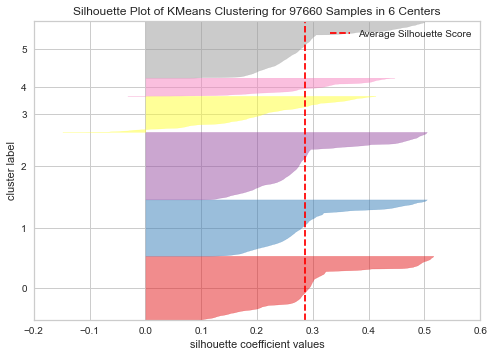

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 97660 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [54]:
# Instantiate the clustering model and visualizer
visualizer_feat6 = SilhouetteVisualizer(kmeans_feat6)

# Fit the data to the visualizer
visualizer_feat6.fit(X_feat_scaled)
visualizer_feat6.poof()  

Les clusters ne se chevauchent pas et sont bien distincts, mais quelques clients ont été mal classés. 

In [55]:
# Affichage des métriques de forme de cluster :
# Silhouette score et Davies Bouldin score
forme_cluster = calc_metrics('RFM Kmeans + feat 6', X_feat_scaled,
                             kmeans_feat6.labels_, forme_cluster)

display(forme_cluster)

,Modèle,Silhouette,Davies Bouldin
0,RFM,-0.053926,2.589299
1,RFM Kmeans,0.528004,0.694183
2,RFM Kmeans + feat 5,0.259236,1.178834
3,RFM Kmeans + feat 6,0.286634,1.146124


In [56]:
# Affichage du métrique de stabilité : Ajusted Rand Index
stabilite_cluster = calc_ari('RFM Kmeans + feat 5', 'RFM Kmeans + feat 6',
                             kmeans_feat.labels_, kmeans_feat6.labels_,
                             stabilite_cluster)

display(stabilite_cluster)

,Modèle 1,Modèle 2,ARI
0,RFM,RFM Kmeans,0.374766
1,RFM Kmeans,RFM Kmeans + feat 5,0.500833
2,RFM Kmeans + feat 5,RFM Kmeans + feat 6,0.640175


### 2.3. Les données après EDA, PCA et Kmeans <a class="anchor" id="section_2_3"></a>

On va effectuer un PCA avant le kmeans pour réduire la dimensionnalité et pour permettre la visualisation des clusters.

In [57]:
# Les données et normalisation des données
cols = df.columns
X_df_kmeans = df.copy()
X_df_kmeans.drop('order_purchase_timestamp', axis=1, inplace=True)
ms_df_kmeans = StandardScaler()
X_scaled_df_kmeans = ms_df_kmeans.fit_transform(X_df_kmeans)

In [58]:
# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca_df_kmeans = PCA(n_components=2)
pca_df_kmeans.fit(X_scaled_df_kmeans)

# Transfor the scaled data to the new PCA space
X_reduced_df_kmeans = pca_df_kmeans.transform(X_scaled_df_kmeans)

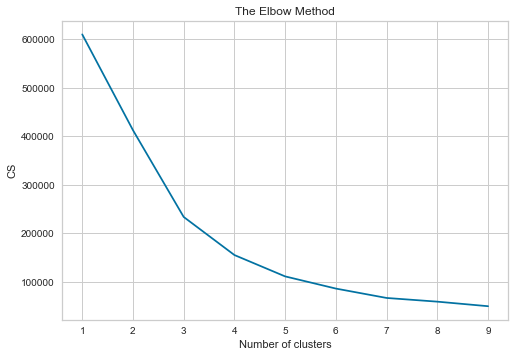

In [59]:
# Nombre de clusters qu'il faut choisir
cs_df_kmeans = []
for i in range(1, 10):
    kmeans_df_kmeans = KMeans(n_clusters=i, init='random',
                              max_iter=300, n_init=10, random_state=0)
    kmeans_df_kmeans.fit(X_reduced_df_kmeans)
    cs_df_kmeans.append(kmeans_df_kmeans.inertia_)
plt.plot(range(1, 10), cs_df_kmeans)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

Sur le graphe ci-dessus, on observe plusieurs coudes, on va donc les tester : 3, 4 et 7. Pour simplifier l'analyse marketing, le choix avec 7 clusters ne sera pas retenu. C'est uniquement pour comparer les résultats et avoir un autre point vu.  

In [60]:
# 3 clusters
kmeans_df_kmeans3 = KMeans(n_clusters=3, init='random',
                           max_iter=300, n_init=10, random_state=0)
kmeans_df_kmeans3.fit(X_reduced_df_kmeans)
y_df_kmeans3 = kmeans_df_kmeans3.fit_predict(X_reduced_df_kmeans)
clusters_df_kmeans3 = kmeans_df_kmeans3.predict(X_reduced_df_kmeans)
centres_reduced_df_kmeans3 = kmeans_df_kmeans3.cluster_centers_

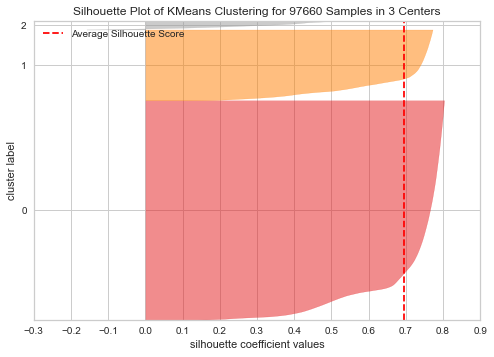

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 97660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [61]:
# Instantiate the clustering model and visualizer
visualizer_df_kmeans = SilhouetteVisualizer(kmeans_df_kmeans3)

# Fit the data to the visualizer
visualizer_df_kmeans.fit(X_reduced_df_kmeans)
visualizer_df_kmeans.poof()

Les clusters ne se chevauchent pas et sont bien distincts.

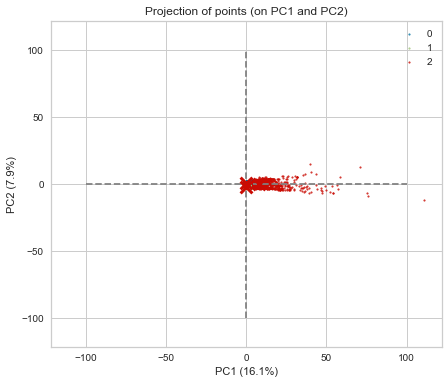

In [62]:
# Affichage
display_factorial_planes2(X_reduced_df_kmeans, 2, pca_df_kmeans,
                         [(0, 1)], illustrative_var=clusters_df_kmeans3,
                         alpha=0.8)
plt.scatter(centres_reduced_df_kmeans3[:, 0],
            centres_reduced_df_kmeans3[:, 1],
            marker='x', s=139, linewidths=3,
            color='r', zorder=10)

In [63]:
# Affichage des métriques de forme de cluster :
# Silhouette score et Davies Bouldin score
forme_cluster = calc_metrics('df Kmeans 3', X_reduced_df_kmeans,
                             kmeans_df_kmeans3.labels_, forme_cluster)

display(forme_cluster)

,Modèle,Silhouette,Davies Bouldin
0,RFM,-0.053926,2.589299
1,RFM Kmeans,0.528004,0.694183
2,RFM Kmeans + feat 5,0.259236,1.178834
3,RFM Kmeans + feat 6,0.286634,1.146124
4,df Kmeans 3,0.694056,0.593844


In [64]:
# Affichage du métrique de stabilité : Ajusted Rand Index
stabilite_cluster = calc_ari('RFM Kmeans + feat 6', 'df Kmeans 3',
                             kmeans_feat6.labels_, kmeans_df_kmeans3.labels_,
                             stabilite_cluster)

display(stabilite_cluster)

,Modèle 1,Modèle 2,ARI
0,RFM,RFM Kmeans,0.374766
1,RFM Kmeans,RFM Kmeans + feat 5,0.500833
2,RFM Kmeans + feat 5,RFM Kmeans + feat 6,0.640175
3,RFM Kmeans + feat 6,df Kmeans 3,0.003327


In [65]:
# 4 clusters
kmeans_df_kmeans = KMeans(n_clusters=4, init='random',
                          max_iter=300, n_init=10, random_state=0)
kmeans_df_kmeans.fit(X_reduced_df_kmeans)
y_df_kmeans = kmeans_df_kmeans.fit_predict(X_reduced_df_kmeans)
clusters_df_kmeans = kmeans_df_kmeans.predict(X_reduced_df_kmeans)
centres_reduced_df_kmeans = kmeans_df_kmeans.cluster_centers_

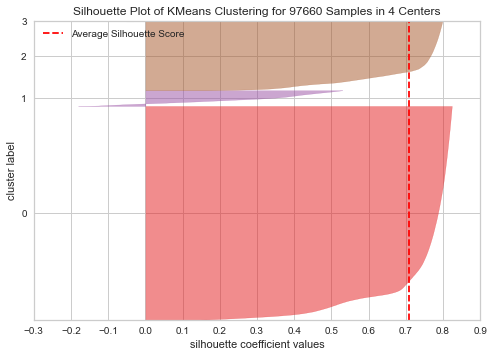

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 97660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [66]:
# Instantiate the clustering model and visualizer
visualizer_df_kmeans = SilhouetteVisualizer(kmeans_df_kmeans)

# Fit the data to the visualizer
visualizer_df_kmeans.fit(X_reduced_df_kmeans)
visualizer_df_kmeans.poof()

Les clusters ne se chevauchent pas et sont bien distincts.

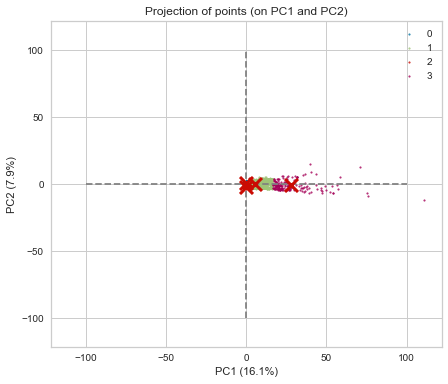

In [67]:
# Affichage
display_factorial_planes2(X_reduced_df_kmeans, 2, pca_df_kmeans,
                         [(0, 1)], illustrative_var=clusters_df_kmeans,
                         alpha=0.8)
plt.scatter(centres_reduced_df_kmeans[:, 0],
            centres_reduced_df_kmeans[:, 1],
            marker='x', s=169, linewidths=3,
            color='r', zorder=10)

In [68]:
# Affichage des métriques de forme de cluster :
# Silhouette score et Davies Bouldin score
forme_cluster = calc_metrics('df Kmeans 4', X_reduced_df_kmeans,
                             kmeans_df_kmeans.labels_, forme_cluster)

display(forme_cluster)

,Modèle,Silhouette,Davies Bouldin
0,RFM,-0.053926,2.589299
1,RFM Kmeans,0.528004,0.694183
2,RFM Kmeans + feat 5,0.259236,1.178834
3,RFM Kmeans + feat 6,0.286634,1.146124
4,df Kmeans 3,0.694056,0.593844
5,df Kmeans 4,0.708505,0.593954


In [69]:
# Affichage du métrique de stabilité : Ajusted Rand Index
stabilite_cluster = calc_ari('df Kmeans 3', 'df Kmeans 4',
                             kmeans_df_kmeans3.labels_,
                             kmeans_df_kmeans.labels_,
                             stabilite_cluster)

display(stabilite_cluster)

,Modèle 1,Modèle 2,ARI
0,RFM,RFM Kmeans,0.374766
1,RFM Kmeans,RFM Kmeans + feat 5,0.500833
2,RFM Kmeans + feat 5,RFM Kmeans + feat 6,0.640175
3,RFM Kmeans + feat 6,df Kmeans 3,0.003327
4,df Kmeans 3,df Kmeans 4,0.934920


In [70]:
# 7 clusters
kmeans_df_kmeans7 = KMeans(n_clusters=7, init='random',
                           max_iter=300, n_init=10, random_state=0)
kmeans_df_kmeans7.fit(X_reduced_df_kmeans)
y_df_kmeans7 = kmeans_df_kmeans7.fit_predict(X_reduced_df_kmeans)
clusters_df_kmeans7 = kmeans_df_kmeans7.predict(X_reduced_df_kmeans)
centres_reduced_df_kmeans7 = kmeans_df_kmeans7.cluster_centers_

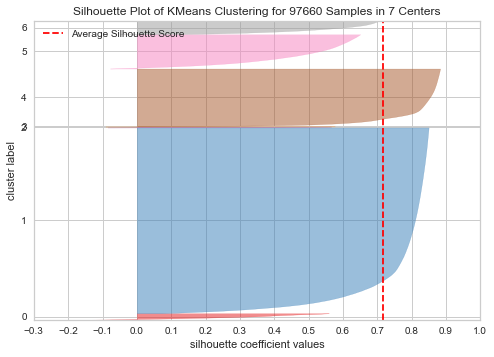

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 97660 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [71]:
# Instantiate the clustering model and visualizer
visualizer_df_kmeans7 = SilhouetteVisualizer(kmeans_df_kmeans7)

# Fit the data to the visualizer
visualizer_df_kmeans7.fit(X_reduced_df_kmeans)
visualizer_df_kmeans7.poof()

Les clusters ne se chevauchent pas et sont bien distincts, mais quelques clients ont été mal classés. De plus, certains clusters contiennent très peu de clients. Par exemple, le cluster 'bleu' contient nettement moins d'individus que le cluster 'violet'. En fin de compte, segmenter en 7 catégories les clients, augmente la complexité pour le marketing. De ce fait, on retiendra la solution avec un faible nombre de clusters.

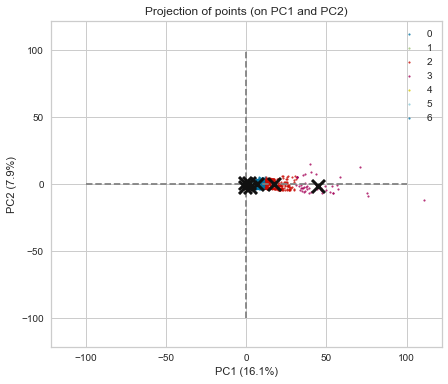

In [72]:
# Affichage
display_factorial_planes2(X_reduced_df_kmeans, 2, pca_df_kmeans,
                         [(0, 1)], illustrative_var=clusters_df_kmeans7,
                         alpha=0.8)
plt.scatter(centres_reduced_df_kmeans7[:, 0],
            centres_reduced_df_kmeans7[:, 1],
            marker='x', s=169, linewidths=3,
            color='k', zorder=10)

In [73]:
# Affichage des métriques de forme de cluster :
# Silhouette score et Davies Bouldin score
forme_cluster = calc_metrics('df Kmeans 7', X_reduced_df_kmeans,
                             kmeans_df_kmeans7.labels_, forme_cluster)

display(forme_cluster)

,Modèle,Silhouette,Davies Bouldin
0,RFM,-0.053926,2.589299
1,RFM Kmeans,0.528004,0.694183
2,RFM Kmeans + feat 5,0.259236,1.178834
3,RFM Kmeans + feat 6,0.286634,1.146124
4,df Kmeans 3,0.694056,0.593844
5,df Kmeans 4,0.708505,0.593954
6,df Kmeans 7,0.716495,0.609214


In [74]:
# Affichage du métrique de stabilité : Ajusted Rand Index
stabilite_cluster = calc_ari('df Kmeans 4', 'df Kmeans 7',
                             kmeans_df_kmeans.labels_,
                             kmeans_df_kmeans7.labels_,
                             stabilite_cluster)

display(stabilite_cluster)

,Modèle 1,Modèle 2,ARI
0,RFM,RFM Kmeans,0.374766
1,RFM Kmeans,RFM Kmeans + feat 5,0.500833
2,RFM Kmeans + feat 5,RFM Kmeans + feat 6,0.640175
3,RFM Kmeans + feat 6,df Kmeans 3,0.003327
4,df Kmeans 3,df Kmeans 4,0.934920
5,df Kmeans 4,df Kmeans 7,0.730394


## 3. DBSCAN <a class="anchor" id="chapter3"></a>

Le DBSCAN est un algorithme simple qui définit des clusters en utilisant l'estimation de la densité locale. On peut le diviser en 4 étapes : 
- Pour chaque observation, on regarde le nombre de points à une distance ε de celle-ci. On appelle cette zone le ε-voisinage de l'observation.
- Si une observation compte au moins un certain nombre de voisins y compris elle-même, elle est considérée comme une observation cœur. On a alors décelé une observation à haute densité. 
- Toutes les observations au voisinage d'une observation cœur appartiennent au même cluster. Il peut y avoir des observations cœur proche les unes des autres. Par conséquent, de proche en proche, on obtient une longue séquence d'observations cœur qui constitue un unique cluster. 
- Toute observation qui n'est pas une observation cœur et qui ne comporte pas d'observation cœur dans son voisinage est considérée comme une anomalie. 

On a besoin de définir deux informations avant d'utiliser le DBSCAN :
- La distance ε pour déterminer pour chaque observation le ε-voisinage,
- Le nombre minimal de voisins nécessaire pour considérer qu'une observation est une observation cœur

Je décide d'utiliser le jeu de données issu de l'analyse exploratoire et du nettoyage. On observera les résultats en 2 et en 3 dimensions pour cet algorithme. Puis, on cherchera à optimiser les deux paramètres de cet algorithme. 

### 3.1. PCA 2 + DBSCAN <a class="anchor" id="section_3_1"></a>

In [75]:
# Les données et normalisation des données
cols = df.columns
X_df_DBSCAN = df.copy()
X_df_DBSCAN.drop('order_purchase_timestamp', axis=1, inplace=True)
ms_df_DBSCAN = MinMaxScaler()
X_scaled_df_DBSCAN = ms_df_DBSCAN.fit_transform(X_df_DBSCAN)

In [76]:
# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca_df_DBSCAN = PCA(n_components=2)
pca_df_DBSCAN.fit(X_scaled_df_DBSCAN)

# Transfor the scaled data to the new PCA space
X_reduced_df_DBSCAN = pca_df_DBSCAN.transform(X_scaled_df_DBSCAN)

(0.0, 0.0025)

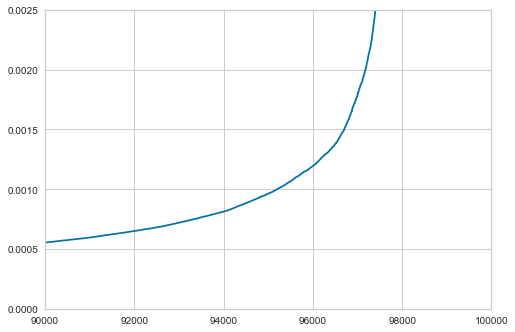

In [77]:
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(X_reduced_df_DBSCAN)
distances, indices = neighbors_fit.kneighbors(X_reduced_df_DBSCAN)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)
plt.xlim([90000, 100000])
plt.ylim([0.000, 0.0025])

In [78]:
db = DBSCAN(eps=0.0025, min_samples=200, metric='euclidean')
db.fit(X_reduced_df_DBSCAN)
y_df_DBSCAN = db.fit_predict(X_reduced_df_DBSCAN)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 12
Estimated number of noise points: 44824


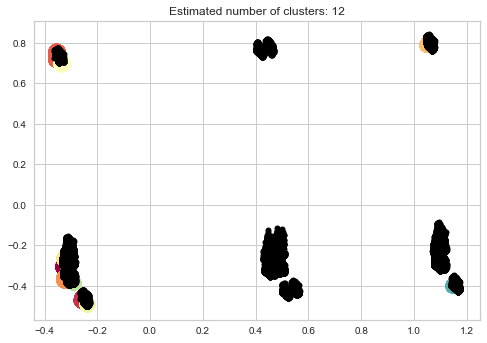

In [79]:
# Black removed and is used for noise instead.
plot_dbscan_2d(db, X_reduced_df_DBSCAN)

In [80]:
# Affichage des métriques de forme de cluster :
# Silhouette score et Davies Bouldin score
forme_cluster = calc_metrics('df DBSCAN', X_reduced_df_DBSCAN,
                             db.labels_, forme_cluster)

display(forme_cluster)

,Modèle,Silhouette,Davies Bouldin
0,RFM,-0.053926,2.589299
1,RFM Kmeans,0.528004,0.694183
2,RFM Kmeans + feat 5,0.259236,1.178834
3,RFM Kmeans + feat 6,0.286634,1.146124
4,df Kmeans 3,0.694056,0.593844
5,df Kmeans 4,0.708505,0.593954
6,df Kmeans 7,0.716495,0.609214
7,df DBSCAN,-0.074288,1.008112


In [81]:
# Affichage du métrique de stabilité : Ajusted Rand Index
stabilite_cluster = calc_ari('df Kmeans 7', 'df DBSCAN',
                             kmeans_df_kmeans7.labels_, db.labels_,
                             stabilite_cluster)

display(stabilite_cluster)

,Modèle 1,Modèle 2,ARI
0,RFM,RFM Kmeans,0.374766
1,RFM Kmeans,RFM Kmeans + feat 5,0.500833
2,RFM Kmeans + feat 5,RFM Kmeans + feat 6,0.640175
3,RFM Kmeans + feat 6,df Kmeans 3,0.003327
4,df Kmeans 3,df Kmeans 4,0.934920
5,df Kmeans 4,df Kmeans 7,0.730394
6,df Kmeans 7,df DBSCAN,-0.038468


### 3.2. PCA 3 + DBSCAN <a class="anchor" id="section_3_2"></a>

In [82]:
# Create a PCA model to reduce our data to 3 dimensions for visualisation
pca_df_DBSCAN = PCA(n_components=3)
pca_df_DBSCAN.fit(X_scaled_df_DBSCAN)

# Transfor the scaled data to the new PCA space
X_reduced_df_DBSCAN3 = pca_df_DBSCAN.transform(X_scaled_df_DBSCAN)

In [83]:
db3 = DBSCAN(eps=0.0025, min_samples=200, metric='euclidean')
db3.fit(X_reduced_df_DBSCAN3)
y_df_DBSCAN3 = db3.fit_predict(X_reduced_df_DBSCAN3)
labels3 = db3.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_3 = len(set(labels3)) - (1 if -1 in labels else 0)
n_noise_3 = list(labels3).count(-1)

print('Estimated number of clusters: %d' % n_clusters_3)
print('Estimated number of noise points: %d' % n_noise_3)

Estimated number of clusters: 8
Estimated number of noise points: 80124


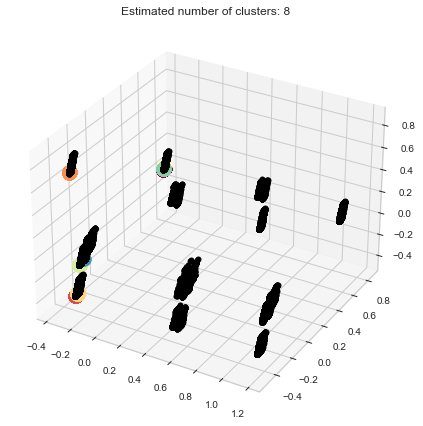

In [84]:
# Affichage 3d dbscan
plot_dbscan_3d(db3, X_reduced_df_DBSCAN3)

In [85]:
# Affichage des métriques de forme de cluster :
# Silhouette score et Davies Bouldin score
forme_cluster = calc_metrics('df DBSCAN 3', X_reduced_df_DBSCAN3,
                             db3.labels_, forme_cluster)

display(forme_cluster)

,Modèle,Silhouette,Davies Bouldin
0,RFM,-0.053926,2.589299
1,RFM Kmeans,0.528004,0.694183
2,RFM Kmeans + feat 5,0.259236,1.178834
3,RFM Kmeans + feat 6,0.286634,1.146124
4,df Kmeans 3,0.694056,0.593844
5,df Kmeans 4,0.708505,0.593954
6,df Kmeans 7,0.716495,0.609214
7,df DBSCAN,-0.074288,1.008112
8,df DBSCAN 3,-0.431554,1.229630


In [86]:
# Affichage du métrique de stabilité : Ajusted Rand Index
stabilite_cluster = calc_ari('df DBSCAN', 'df DBSCAN 3',
                             db.labels_, db3.labels_,
                             stabilite_cluster)

display(stabilite_cluster)

,Modèle 1,Modèle 2,ARI
0,RFM,RFM Kmeans,0.374766
1,RFM Kmeans,RFM Kmeans + feat 5,0.500833
2,RFM Kmeans + feat 5,RFM Kmeans + feat 6,0.640175
3,RFM Kmeans + feat 6,df Kmeans 3,0.003327
4,df Kmeans 3,df Kmeans 4,0.934920
5,df Kmeans 4,df Kmeans 7,0.730394
6,df Kmeans 7,df DBSCAN,-0.038468
7,df DBSCAN,df DBSCAN 3,0.198637


### 3.3. Optimisation des paramètres pour DBSCAN (2d) <a class="anchor" id="section_3_3"></a>

Mon critère d'optimisation est le nombre de clusters le plus faible possible afin de simplifier les démarches marketing. Je cherche donc à savoir la combinaison de paramètres pour laquelle le nombre de clusters est le plus faible.

In [87]:
# Optimisation des paramètres
EPS = [0.0005, 0.0015, 0.0020, 0.005]
MinSamples = [50, 100, 200, 300]

cluster_param = set_parameter_dbscan(EPS, MinSamples, X_reduced_df_DBSCAN)
display(cluster_param)

,n_clus,n_noise,eps,min_sample
0,36.0,89000.0,0.0005,50.0
1,6.0,96030.0,0.0005,100.0
2,0.0,97660.0,0.0005,200.0
3,0.0,97660.0,0.0005,300.0
4,43.0,33821.0,0.0015,50.0
5,26.0,54711.0,0.0015,100.0
6,8.0,77592.0,0.0015,200.0
7,4.0,86202.0,0.0015,300.0
8,31.0,20112.0,0.0020,50.0
9,23.0,37763.0,0.0020,100.0


In [88]:
# Le nombre de clusters = 4
eps_opt = 0.0015
min_sample_opt = 300
db_opt = calc_dbscan(eps_opt, min_sample_opt, X_reduced_df_DBSCAN)

Estimated number of clusters: 4
Estimated number of noise points: 86202


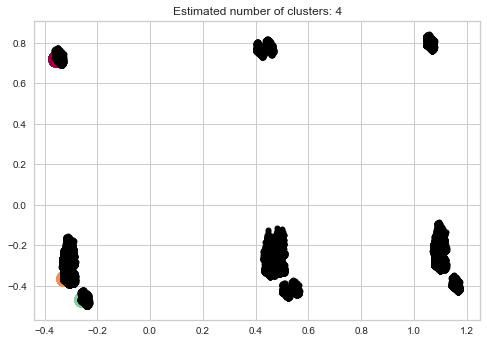

In [89]:
# Affichage dbscan 2d
plot_dbscan_2d(db_opt, X_reduced_df_DBSCAN)

In [90]:
# Affichage des métriques de forme de cluster :
# Silhouette score et Davies Bouldin score
forme_cluster = calc_metrics('df DBSCAN opt', X_reduced_df_DBSCAN,
                             db_opt.labels_, forme_cluster)

display(forme_cluster)

,Modèle,Silhouette,Davies Bouldin
0,RFM,-0.053926,2.589299
1,RFM Kmeans,0.528004,0.694183
2,RFM Kmeans + feat 5,0.259236,1.178834
3,RFM Kmeans + feat 6,0.286634,1.146124
4,df Kmeans 3,0.694056,0.593844
5,df Kmeans 4,0.708505,0.593954
6,df Kmeans 7,0.716495,0.609214
7,df DBSCAN,-0.074288,1.008112
8,df DBSCAN 3,-0.431554,1.229630
9,df DBSCAN opt,-0.471740,1.306913


In [91]:
# Affichage du métrique de stabilité : Ajusted Rand Index
stabilite_cluster = calc_ari('df DBSCAN 3', 'df DBSCAN opt',
                             db3.labels_, db_opt.labels_,
                             stabilite_cluster)

display(stabilite_cluster)

,Modèle 1,Modèle 2,ARI
0,RFM,RFM Kmeans,0.374766
1,RFM Kmeans,RFM Kmeans + feat 5,0.500833
2,RFM Kmeans + feat 5,RFM Kmeans + feat 6,0.640175
3,RFM Kmeans + feat 6,df Kmeans 3,0.003327
4,df Kmeans 3,df Kmeans 4,0.934920
5,df Kmeans 4,df Kmeans 7,0.730394
6,df Kmeans 7,df DBSCAN,-0.038468
7,df DBSCAN,df DBSCAN 3,0.198637
8,df DBSCAN 3,df DBSCAN opt,0.614668


### 3.4. Optimisation des paramètres pour DBSCAN (3d) <a class="anchor" id="section_3_4"></a>

In [92]:
# Optimisation des paramètres pour 3 clusters
EPS = [0.0005, 0.0015, 0.0020, 0.005]
MinSamples = [50, 100, 200, 300]

cluster_param3 = set_parameter_dbscan(EPS, MinSamples, X_reduced_df_DBSCAN3)
display(cluster_param3)

,n_clus,n_noise,eps,min_sample
0,8.0,96832.0,0.0005,50.0
1,0.0,97660.0,0.0005,100.0
2,0.0,97660.0,0.0005,200.0
3,0.0,97660.0,0.0005,300.0
4,59.0,68630.0,0.0015,50.0
5,18.0,83524.0,0.0015,100.0
6,1.0,93814.0,0.0015,200.0
7,1.0,96477.0,0.0015,300.0
8,53.0,56281.0,0.0020,50.0
9,21.0,73968.0,0.0020,100.0


In [93]:
# Le nombre de clusters = 6
eps_opt = 0.0020
min_sample_opt = 200

db_opt3 = calc_dbscan(eps_opt, min_sample_opt, X_reduced_df_DBSCAN3)

Estimated number of clusters: 6
Estimated number of noise points: 88208


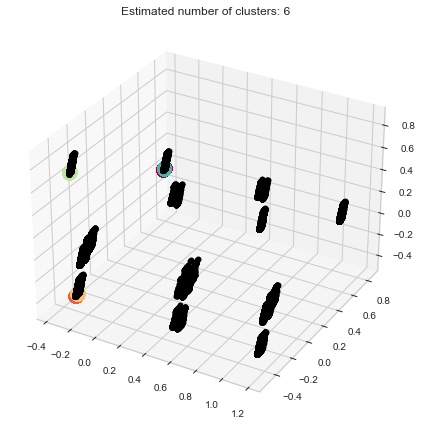

In [94]:
# Affichage dbscan 3d
plot_dbscan_3d(db_opt3, X_reduced_df_DBSCAN3)

In [95]:
# Affichage des métriques de forme de cluster :
# Silhouette score et Davies Bouldin score
forme_cluster = calc_metrics('df DBSCAN 3 opt', X_reduced_df_DBSCAN3,
                             db_opt3.labels_, forme_cluster)

display(forme_cluster)

,Modèle,Silhouette,Davies Bouldin
0,RFM,-0.053926,2.589299
1,RFM Kmeans,0.528004,0.694183
2,RFM Kmeans + feat 5,0.259236,1.178834
3,RFM Kmeans + feat 6,0.286634,1.146124
4,df Kmeans 3,0.694056,0.593844
5,df Kmeans 4,0.708505,0.593954
6,df Kmeans 7,0.716495,0.609214
7,df DBSCAN,-0.074288,1.008112
8,df DBSCAN 3,-0.431554,1.229630
9,df DBSCAN opt,-0.471740,1.306913


In [96]:
# Affichage du métrique de stabilité : Ajusted Rand Index
stabilite_cluster = calc_ari('df DBSCAN opt', 'df DBSCAN 3 opt',
                             db_opt.labels_, db_opt3.labels_,
                             stabilite_cluster)

display(stabilite_cluster)

,Modèle 1,Modèle 2,ARI
0,RFM,RFM Kmeans,0.374766
1,RFM Kmeans,RFM Kmeans + feat 5,0.500833
2,RFM Kmeans + feat 5,RFM Kmeans + feat 6,0.640175
3,RFM Kmeans + feat 6,df Kmeans 3,0.003327
4,df Kmeans 3,df Kmeans 4,0.934920
5,df Kmeans 4,df Kmeans 7,0.730394
6,df Kmeans 7,df DBSCAN,-0.038468
7,df DBSCAN,df DBSCAN 3,0.198637
8,df DBSCAN 3,df DBSCAN opt,0.614668
9,df DBSCAN opt,df DBSCAN 3 opt,0.799261


### 3.5. Comparatif des modèles <a class="anchor" id="section_3_5"></a>

In [97]:
# Modification de df pour l'affichage
forme_cluster_aff = forme_cluster.set_index("Modèle")

AxesSubplot(0.125,0.125;0.775x0.755)


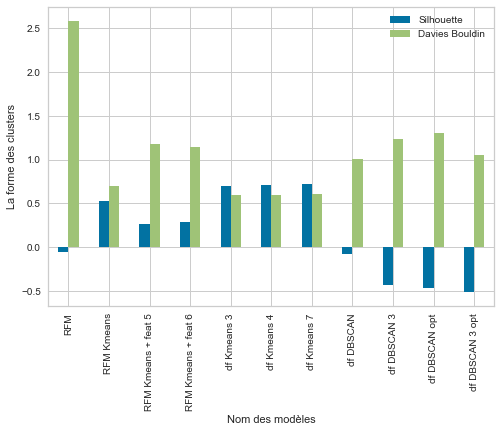

In [98]:
# Comparatif silhouette & davies bouldin
axis = forme_cluster_aff.plot.bar(rot=0)
axis.set_xlabel('Nom des modèles')
axis.set_ylabel('La forme des clusters')
axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
print(axis)
plt.show()

In [99]:
# Modification de df pour l'affichage
stabilite_cluster_aff = stabilite_cluster.set_index("Modèle 1")

AxesSubplot(0.125,0.125;0.775x0.755)


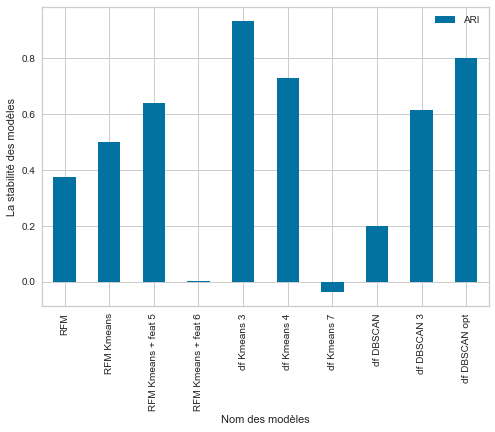

In [100]:
axis = stabilite_cluster_aff.plot.bar(rot=0)
axis.set_xlabel('Nom des modèles')
axis.set_ylabel('La stabilité des modèles')
axis.set_xticklabels(axis.get_xticklabels(),rotation=90)
print(axis)
plt.show()

In [101]:
# Enregistrer la session notebook
#dill.dump_session('notebook_env_0809.db')

In [102]:
#%pycodestyle_off

## 4. Clustering hiérarchique <a class="anchor" id="chapter4"></a>

Le principe de la classification ascendante hiérarchique (CAH) est de rassembler des individus selon un critère de ressemblance défini au préalable qui s'exprimera sous la forme d'une matrice de distances, exprimant la distance existant entre chaque individu pris deux à deux. Deux observations identiques auront une distance nulle. Plus les deux observations seront dissemblables, plus la distance sera importante. La CAH va ensuite rassembler les individus de manière itérative afin de produire un dendrogramme ou arbre de classification. La classification est ascendante, car elle part des observations individuelles ; elle est hiérarchique, car elle produit des classes ou groupes de plus en plus vastes, incluant des sous-groupes en leur sein. En découpant cet arbre à une certaine hauteur choisie, on produira la partition désirée.

Le calcul de distance lors de cet algorithme est très chronophage, de ce fait, je décide de travailler sur un échantillon  (1/10) du jeu de données.

In [103]:
# Normalisation des données
colsFeat = df.columns
X_hie = df.copy()
X_hie.drop('order_purchase_timestamp', axis=1, inplace=True)
X_hie = X_hie.sample(frac=0.1)
display(X_hie.shape)
ms_hie = StandardScaler()
X_scaled_hie = ms_hie.fit_transform(X_hie)
display(X_scaled_hie.shape)

(9766, 26)

(9766, 26)

In [104]:
# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca_df_hie = PCA(n_components=2)
pca_df_hie.fit(X_scaled_hie)

# Transfor the scaled data to the new PCA space
X_reduced_hie = pca_df_hie.transform(X_scaled_hie)
display(X_reduced_hie.shape)

(9766, 2)

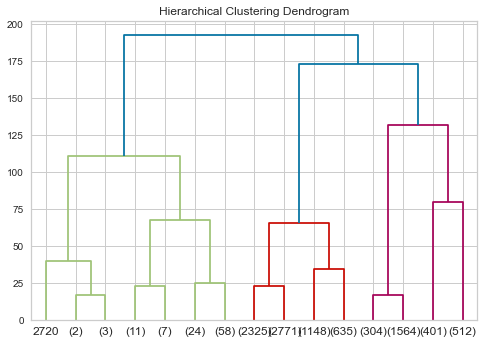

In [105]:
# setting distance_threshold=0 ensures we compute the full tree.
Agg_Clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

Agg_Clustering = Agg_Clustering.fit(X_reduced_hie)
plt.title('Hierarchical Clustering Dendrogram')

# plot the top three levels of the dendrogram
plot_dendrogram(Agg_Clustering, truncate_mode='level', p=3)

Text(0.5, 1.0, 'Agglomerative Clustering')

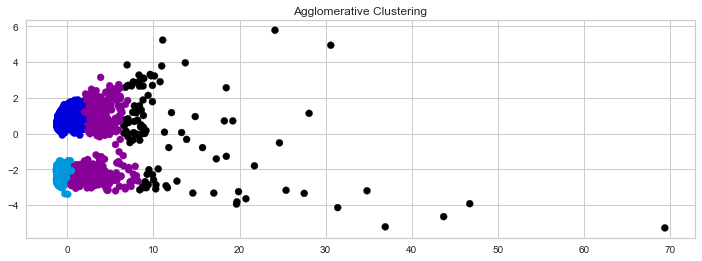

In [106]:
# Get the cluster labels and plot
Agg_Clustering_model = AgglomerativeClustering(n_clusters=4, linkage='ward')
clustering = Agg_Clustering_model.fit(X_reduced_hie)

plt.figure(figsize=(12, 4))

#plot_scatter(X_reduced_hie, cluster_labels)
plt.scatter(X_reduced_hie[:, 0], X_reduced_hie[:, 1],
            c=plt.cm.nipy_spectral(clustering.labels_ / 10.))
plt.title("Agglomerative Clustering")

In [107]:
# Affichage des métriques de forme de cluster :
# Silhouette score et Davies Bouldin score
forme_cluster = calc_metrics('df Agg Clus', X_reduced_hie,
                             clustering.labels_, forme_cluster)

display(forme_cluster)

,Modèle,Silhouette,Davies Bouldin
0,RFM,-0.053926,2.589299
1,RFM Kmeans,0.528004,0.694183
2,RFM Kmeans + feat 5,0.259236,1.178834
3,RFM Kmeans + feat 6,0.286634,1.146124
4,df Kmeans 3,0.694056,0.593844
5,df Kmeans 4,0.708505,0.593954
6,df Kmeans 7,0.716495,0.609214
7,df DBSCAN,-0.074288,1.008112
8,df DBSCAN 3,-0.431554,1.229630
9,df DBSCAN opt,-0.471740,1.306913


AxesSubplot(0.125,0.125;0.775x0.755)


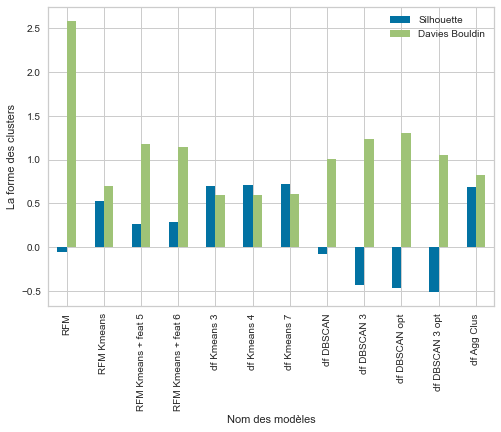

In [108]:
# Comparatif des modèles

# Modification de df pour l'affichage
forme_cluster_aff = forme_cluster.set_index("Modèle")

# Comparatif silhouette & davies bouldin
axis = forme_cluster_aff.plot.bar(rot=0)
axis.set_xlabel('Nom des modèles')
axis.set_ylabel('La forme des clusters')
axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
print(axis)
plt.show()

## 5. Choix du modèle et observations <a class="anchor" id="chapter5"></a>

En regardant les métriques de forme, on observe que l'algorithme kmeans avec un nombre de clusters fixé à 4 permet d'avoir de meilleures performances. L'algorithme DBSCAN, n'est pas adapté dans ce contexte de classification. En effet, les individus sont mal classés de plus et les métriques de formes sont assez mauvaises. En ce qui concerne la classification ascendante hiérarchique, elle présente des performances très proche de l'algorithme kmeans. L'inconvénient c'est qu'elle est très chronophage, car le calcul de la matrice des distances nécessite du temps. Je n'ai pu tester cet algorithme que sur un échantillon du jeu de données.

### 5.1. Modèle final <a class="anchor" id="section_5_1"></a>

In [109]:
#%load_ext pycodestyle_magic

In [110]:
#%pycodestyle_on

In [111]:
# Add cluster number to the original data
X_scaled_df_kmeans_clustered = pd.DataFrame(X_df_kmeans,
                                            columns=X_df_kmeans.columns,
                                            index=X_df_kmeans.index)
X_scaled_df_kmeans_clustered['cluster'] = clusters_df_kmeans

X_scaled_df_kmeans_clustered.head()

,customer_zip_code_prefix,delivery_delta_days,nb_payment_sequential,sum_payment_installments,is_reviewed,review_score,mean_nb_items,nb_orders,sum_price,sum_freight,...,product_category_fashion_clothing_accessories,product_category_flowers_gifts,product_category_groceries_food_drink,product_category_health_beauty,product_category_home_furniture,product_category_other,product_category_sport,product_category_technology,product_category_toys_baby,cluster
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
871766c5855e863f6eccc05f988b23cb,28013,8,1,2,1,5,1.0,1,58.90,13.29,...,0,1,0,0,0,0,0,0,0,0
eb28e67c4c0b83846050ddfb8a35d051,15775,16,1,3,1,4,1.0,2,252.78,31.78,...,0,0,0,0,0,1,0,0,0,0
eb28e67c4c0b83846050ddfb8a35d051,15775,7,1,1,1,5,1.0,2,252.78,31.78,...,0,0,0,0,0,0,0,1,0,0
3818d81c6709e39d06b2738a8d3a2474,35661,8,1,5,1,5,1.0,1,199.00,17.87,...,0,0,0,0,1,0,0,0,0,0
af861d436cfc08b2c2ddefd0ba074622,12952,6,1,2,1,4,1.0,1,12.99,12.79,...,0,0,0,1,0,0,0,0,0,0


In [112]:
# Affichage des moyennes
moy_kmeans = X_scaled_df_kmeans_clustered.groupby('cluster')\
    .agg(RecencyMean=('recency', 'mean'),
         SumMean=('sum_price', 'mean'),
         NbOrders=('nb_orders', 'mean'),
         GroupSize=('recency', 'size'))
moy_kmeans = moy_kmeans.reset_index()
display(moy_kmeans)

,cluster,RecencyMean,SumMean,NbOrders,GroupSize
0,0,245.521875,138.495970,1.062642,69873
1,1,244.909410,512.658593,1.276641,5133
2,2,251.750478,119.127957,1.064215,22487
3,3,262.754491,2067.735389,1.209581,167


In [113]:
# Personea
personea = X_scaled_df_kmeans_clustered.groupby('cluster').head(2)
personea_reduce = personea[['recency', 'nb_orders',
                            'sum_payment_installments',
                            'sum_price', 'cluster']]
display(personea_reduce.sort_values('cluster'))

,recency,nb_orders,sum_payment_installments,sum_price,cluster
customer_unique_id,,,,,
871766c5855e863f6eccc05f988b23cb,358,1,2,58.90,0
eb28e67c4c0b83846050ddfb8a35d051,356,2,3,252.78,0
bb8a37225e0279ac8a274c9765617eaf,330,1,3,63.99,1
7e59d854b9bb4cbb2c85fcd93877c694,35,1,12,135.56,1
85c835d128beae5b4ce8602c491bf385,483,1,1,21.90,2
9e4159995424971423b98c4a8bc11529,204,1,2,99.80,2
c8460e4251689ba205045f3ea17884a1,29,4,36,4080.00,3
c8460e4251689ba205045f3ea17884a1,29,4,36,4080.00,3


In [177]:
# Random personea
size = 1        # sample size
replace = True  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
testX = X_scaled_df_kmeans_clustered.groupby('cluster', as_index=False).apply(fn)
testX_reduce = testX[['recency', 'nb_orders',
                      'sum_payment_installments',
                      'sum_price', 'cluster', 'review_score']]
testX_reduce

,,recency,nb_orders,sum_payment_installments,sum_price,cluster,review_score
,customer_unique_id,,,,,,
0,a9fa874c06644dd6933dc79aff70540f,478,1,7,89.99,0,5
1,2d10ba74e58f46cf7e01fd715430f89c,112,1,9,105.00,1,4
2,335dcf460d147c60540ebd4920232306,203,1,1,159.90,2,3
3,12138e8ba93973c9b561253683f5581b,98,1,7,1330.00,3,1


In [119]:
# à executer si X_df_kmeans contient la colonne cluster
X_df_kmeans.drop('cluster', axis=1, inplace=True)

# Nombre d'observations
n = X_df_kmeans.shape[0]

# Nombre de variables
p = X_df_kmeans.shape[1]

# Calcul des valeurs propres
eigval = pca_df_kmeans.singular_values_**2/n
print('Les valeurs singulières')
print(eigval)

Les valeurs singulières
[4.19383186 2.05579026]


In [120]:
# Racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)
q = len(eigval)

# Corrélation des variables avec les axes
corvar = np.zeros((p, q))
for k in range(q) :
    corvar[:, k] = pca_df_kmeans.components_[k, :] * sqrt_eigval[k] 

# Afficher la matrice des corrélations variables x facteurs 
print('La matrice des corrélation')
display(corvar) 

La matrice des corrélation


array([[ 0.04843209, -0.05627765],
       [ 0.05279721, -0.07608078],
       [ 0.92220848, -0.10540788],
       [ 0.57336517,  0.40022207],
       [ 0.92220848, -0.10540788],
       [-0.13598618,  0.01505153],
       [ 0.91914424, -0.10698368],
       [ 0.14265086,  0.03314161],
       [ 0.53627544,  0.09906456],
       [ 0.74872951, -0.01644879],
       [ 0.55592531,  0.09017339],
       [ 0.01041502, -0.0412012 ],
       [-0.09205103, -0.85784404],
       [-0.0288813 ,  0.97161867],
       [-0.03489507, -0.1620588 ],
       [ 0.28036324, -0.31485297],
       [-0.02911826, -0.01572842],
       [-0.01123678, -0.01293813],
       [-0.02082144,  0.07337747],
       [-0.01275925, -0.0152097 ],
       [-0.05074829,  0.04081543],
       [ 0.14248962,  0.03593397],
       [-0.01044202, -0.00467144],
       [-0.02625586, -0.02198388],
       [-0.05103261, -0.12707798],
       [-0.0318931 ,  0.02785255]])

In [124]:
# PCA cosinus carré des variables
X = X_df_kmeans.copy()

cos2var = corvar**2
display(pd.DataFrame({'id' : X.columns, 'COS2_1' : cos2var[:, 0],
                    'COS2_2' : cos2var[:, 1]}).sort_values(by=['COS2_2'],
                                                           ascending=False))

# Contributions
ctrvar = cos2var
for k in range(q):
    ctrvar[:, k] = ctrvar[:, k] / eigval[k]

# On n'affiche que pour les 2 premiers axes
display(pd.DataFrame({'id' : X.columns, 'CTR_1' : ctrvar[:, 0],
                    'CTR_2' : ctrvar[:, 1]}).sort_values(by=['CTR_2'],
                                                           ascending=False))

,id,COS2_1,COS2_2
13,payment_type_credit_card,0.000834,0.944043
12,payment_type_boleto,0.008473,0.735896
3,sum_payment_installments,0.328748,0.160178
15,payment_type_voucher,0.078604,0.099132
14,payment_type_debit_card,0.001218,0.026263
24,product_category_technology,0.002604,0.016149
6,mean_nb_items,0.844826,0.011446
2,nb_payment_sequential,0.850468,0.011111
4,is_reviewed,0.850468,0.011111
8,sum_price,0.287591,0.009814


,id,CTR_1,CTR_2
13,payment_type_credit_card,0.000199,0.459212
12,payment_type_boleto,0.002020,0.357963
3,sum_payment_installments,0.078388,0.077915
15,payment_type_voucher,0.018743,0.048221
14,payment_type_debit_card,0.000290,0.012775
24,product_category_technology,0.000621,0.007855
6,mean_nb_items,0.201445,0.005567
2,nb_payment_sequential,0.202790,0.005405
4,is_reviewed,0.202790,0.005405
8,sum_price,0.068575,0.004774


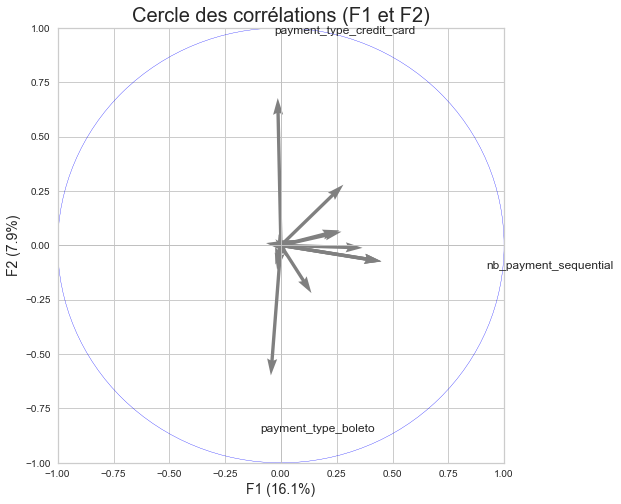

In [125]:
# cercle des corrélations F1 et F2
fig, axes = plt.subplots(figsize=(8, 8)) 
axes.set_xlim(-1, 1) 
axes.set_ylim(-1, 1) 

ind1 = X.columns.get_loc('payment_type_credit_card')
ind2 = X.columns.get_loc('payment_type_boleto')
ind3 = X.columns.get_loc('nb_payment_sequential')

columns_cor = [ind1, ind2, ind3]
# affichage des étiquettes (noms des variables) 
for k in columns_cor: 
    plt.annotate(X.columns[k], (corvar[k, 0], 
                                corvar[k, 1]),
                 fontsize=12) 

# ajouter les axes 
plt.plot([-1, 1], [0, 0], color='silver',
         linestyle='-', linewidth=1) 
plt.plot([0, 0], [-1, 1], color='silver',
         linestyle='-', linewidth=1)

# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(1, round(100*pca_df_kmeans\
                                           .explained_variance_ratio_[0], 1)),
           fontsize=14)
plt.ylabel('F{} ({}%)'.format(2, round(100*pca_df_kmeans\
                                           .explained_variance_ratio_[1], 1)),
           fontsize=14)
plt.title("Cercle des corrélations (F{} et F{})"\
          .format(1, 2), fontsize=20)
pcs = pca_df_kmeans.components_
plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[0, :], pcs[1, :], 
                   angles='xy', scale_units='xy', scale=1, color="grey")

#ajouter un cercle 
cercle = plt.Circle((0, 0), 1, color='blue', fill=False) 
axes.add_artist(cercle) 
plt.show()

Les variables qui ont fortement contribué à la construction des axes sont annotées sur le cercle de corrélation ci-dessus. 

On observe que les variables 'payment_type_credit_card' et 'payment_type_boleto' ont contribué pour la construction de l'axe 2. La première variable est positivement corrélée avec l'axe 2, alors que la deuxième est négativement corrélée.

D'autre part, la variable 'nb_payment_sequential' a contribué à la construction de l'axe 1. Elle est également positivement corrélée avec l'axe 1.

Les deux axes permettent d'expliquer 24 % du jeu de données.

Je décide de vérifier à l'aide d'un scree plot le nombre de composantes nécessaire pour expliquer au moins 80 % du jeu de données.

In [126]:
# Calcul de l'ACP

# instanciation 
acp = PCA(svd_solver='full')

# calculs 
coord = acp.fit_transform(X_scaled_df_kmeans) 

# nombre de composantes calculées 
print('Le nombre de composantes générées par l\'ACP est de :')
display(acp.n_components_)

Le nombre de composantes générées par l'ACP est de :


26

Les valeurs singulières
[4.19383186e+00 2.05580236e+00 1.53699170e+00 1.40943938e+00
 1.32326287e+00 1.16749545e+00 1.15384377e+00 1.13198470e+00
 1.11564824e+00 1.08147044e+00 1.06519554e+00 1.05732846e+00
 1.01719650e+00 1.01141699e+00 9.91111290e-01 9.65953597e-01
 9.04027632e-01 8.38402473e-01 6.04381100e-01 5.58875401e-01
 4.44868167e-01 3.40424116e-01 3.10479645e-02 7.03940032e-32
 6.33558967e-32 2.71539173e-32]
Pourcentage de variance
[1.61301226e+01 7.90693216e+00 5.91150655e+00 5.42092069e+00
 5.08947257e+00 4.49036711e+00 4.43786066e+00 4.35378731e+00
 4.29095475e+00 4.15950170e+00 4.09690593e+00 4.06664792e+00
 3.91229422e+00 3.89006534e+00 3.81196650e+00 3.71520614e+00
 3.47702935e+00 3.22462490e+00 2.32454269e+00 2.14952077e+00
 1.71103141e+00 1.30932352e+00 1.19415248e-01 2.70746166e-31
 2.43676526e-31 1.04438144e-31]


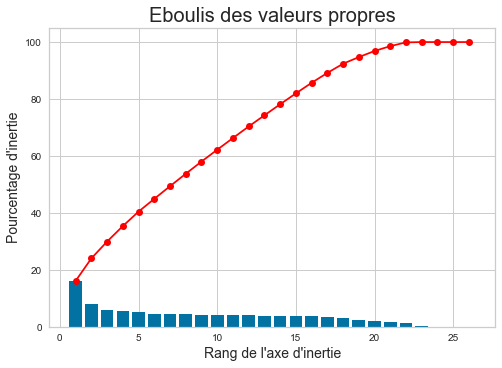

In [127]:
# Calcul des valeurs propres pour déterminer le nombre de composantes principales à prendre en compte

# Calcul des valeurs propres 
eigval_full = acp.singular_values_**2/n
print('Les valeurs singulières')
print(eigval_full)

# cumul de variance expliquée 
scree = acp.explained_variance_ratio_*100
print('Pourcentage de variance')
print(scree)
plt.bar(np.arange(len(scree)) + 1, scree)
plt.plot(np.arange(1, p + 1), scree.cumsum(), c='red', marker='o') 
plt.title("Eboulis des valeurs propres", fontsize=20) 
plt.ylabel("Pourcentage d'inertie", fontsize=14) 
plt.xlabel("Rang de l'axe d'inertie", fontsize=14)  
plt.show()

Même avec 3 composantes, on ne peut expliquer qu'environ 30 % du jeu de données. Je décide de continuer avec les deux composantes pour réaliser quelques illustrations. 

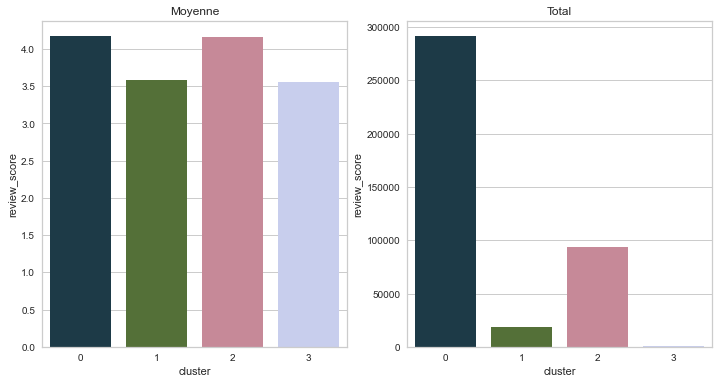

In [128]:
# Le score
variable_etudie = 'review_score'
cluster = 'cluster'
plot_clus(cluster, variable_etudie, X_scaled_df_kmeans_clustered)

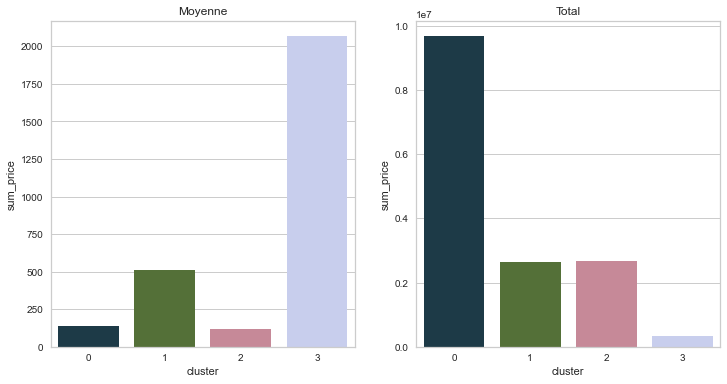

In [129]:
# Le prix
variable_etudie = 'sum_price'
cluster = 'cluster'
plot_clus(cluster, variable_etudie, X_scaled_df_kmeans_clustered)

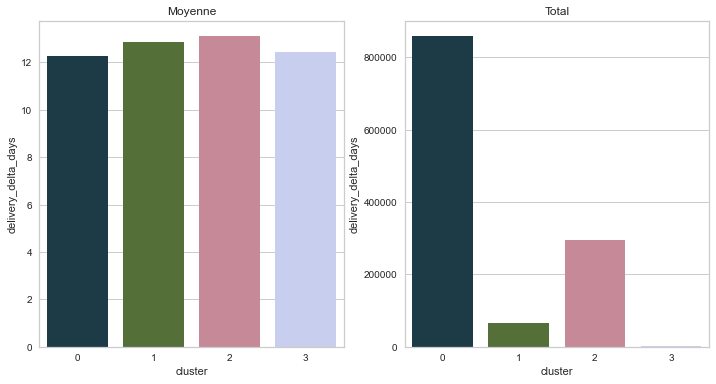

In [130]:
# Le delivery_delta_days
variable_etudie = 'delivery_delta_days'
cluster = 'cluster'
plot_clus(cluster, variable_etudie, X_scaled_df_kmeans_clustered)

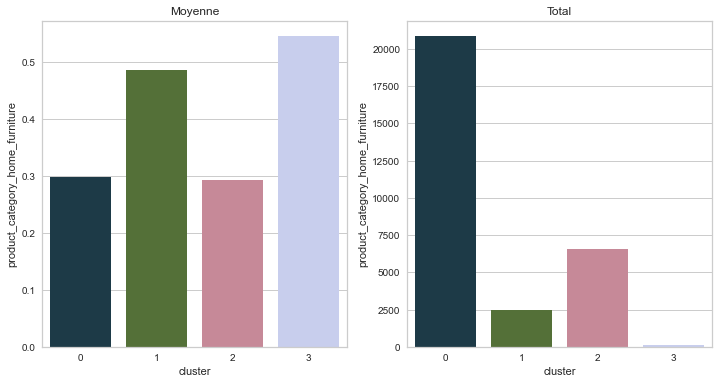

In [131]:
# product_category_home_furniture
variable_etudie = 'product_category_home_furniture'
cluster = 'cluster'
plot_clus(cluster, variable_etudie, X_scaled_df_kmeans_clustered)

0    69873
2    22487
1     5133
3      167
Name: cluster, dtype: int64

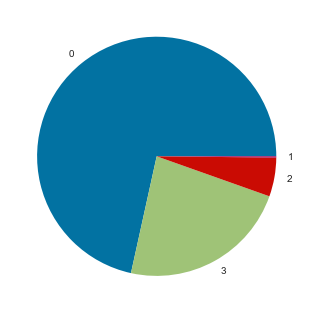

In [132]:
# Nombre de client par cluster
nbr_client_cluster = X_scaled_df_kmeans_clustered[cluster].value_counts()
display(nbr_client_cluster)
plt.pie(nbr_client_cluster, labels=['0', '3', '2', '1'])
plt.show()

In [133]:
#%pycodestyle_off

### 5.2. Modèle final amélioré <a class="anchor" id="section_5_2"></a>

Je cherche à améliorer mon modèle en testant d'autres paramètres pour l'algorithme kmeans.

In [136]:
# Les données et normalisation des données
cols = df.columns
X_kmeans_update = df.copy()
X_kmeans_update.drop('order_purchase_timestamp', axis=1, inplace=True)
ms_kmeans_update = StandardScaler()
X_scaled_kmeans_update = ms_kmeans_update.fit_transform(X_kmeans_update)

In [137]:
# Create a PCA model to reduce our data to 3 dimensions for visualisation
pca_kmeans_update = PCA(n_components=2)
pca_kmeans_update.fit(X_scaled_kmeans_update)

# Transfor the scaled data to the new PCA space
X_reduced_kmeans_update = pca_kmeans_update.transform(X_scaled_kmeans_update)

In [138]:
X_reduced_kmeans_update

array([[-0.91771565,  0.86633676],
       [-0.08589624,  0.8248546 ],
       [-0.33850485,  0.51755992],
       ...,
       [-0.79552949,  0.74702529],
       [-0.97698178,  0.54220801],
       [-0.84673939,  0.75061352]])

In [139]:
# 4 clusters
kmeans_update = KMeans(n_clusters=4, init='k-means++',
                       max_iter=300, n_init=10, random_state=0,
                       algorithm='elkan')
kmeans_update.fit(X_reduced_kmeans_update)
y_kmeans_update = kmeans_update.fit_predict(X_reduced_kmeans_update)
clusters_kmeans_update = kmeans_update.predict(X_reduced_kmeans_update)
centres_reduced_kmeans_update = kmeans_update.cluster_centers_

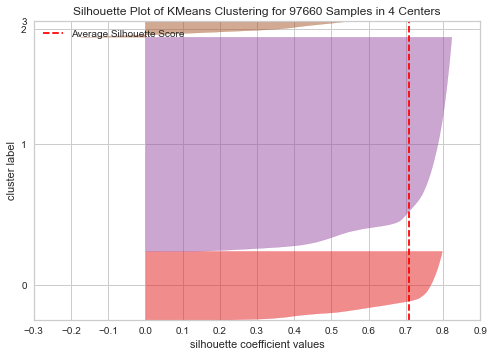

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 97660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [140]:
# Instantiate the clustering model and visualizer
visualizer_df_kmeans = SilhouetteVisualizer(kmeans_update)

# Fit the data to the visualizer
visualizer_df_kmeans.fit(X_reduced_kmeans_update)
visualizer_df_kmeans.poof()

In [141]:
# Nombre d'observations
n2 = X_kmeans_update.shape[0]

# Nombre de variables
p2 = X_kmeans_update.shape[1]

# Calcul des valeurs propres
eigval2 = pca_kmeans_update.singular_values_**2/n
print('Les valeurs singulières')
print(eigval2)

# Racine carrée des valeurs propres
sqrt_eigval2 = np.sqrt(eigval2)
q2 = len(eigval2)

# Corrélation des variables avec les axes
corvar2 = np.zeros((p2, q2))
for k in range(q2) :
    corvar2[:, k] = pca_kmeans_update.components_[k, :] * sqrt_eigval2[k] 

# Afficher la matrice des corrélations variables x facteurs 
print('La matrice des corrélation')
display(corvar2) 

Les valeurs singulières
[4.19383186 2.05575989]
La matrice des corrélation


array([[ 0.04843471, -0.05472239],
       [ 0.05279619, -0.07550546],
       [ 0.92220645, -0.10555045],
       [ 0.57336498,  0.4006926 ],
       [ 0.92220645, -0.10555045],
       [-0.13598068,  0.01549266],
       [ 0.91914238, -0.10711576],
       [ 0.14264778,  0.03053883],
       [ 0.53628037,  0.09945151],
       [ 0.74872957, -0.01678045],
       [ 0.55592687,  0.09024946],
       [ 0.01041868, -0.04073185],
       [-0.09205433, -0.85828849],
       [-0.02888362,  0.97115819],
       [-0.03488926, -0.16026711],
       [ 0.28037169, -0.3140254 ],
       [-0.02910975, -0.01549341],
       [-0.0112438 , -0.01373829],
       [-0.02081488,  0.07654049],
       [-0.01276848, -0.01443749],
       [-0.0507391 ,  0.03815204],
       [ 0.14249437,  0.03658448],
       [-0.01044655, -0.00346159],
       [-0.02626651, -0.0257638 ],
       [-0.05103626, -0.1286574 ],
       [-0.03189335,  0.03134073]])

In [142]:
# PCA cosinus carré des variables
X2 = X_kmeans_update.copy()

cos2var2 = corvar2**2
#display(pd.DataFrame({'id' : X2.columns, 'COS2_1' : cos2var2[:, 0],
#                    'COS2_2' : cos2var2[:, 1], 'COS2_3' : cos2var2[:, 2]})\
#                    .sort_values(by=['COS2_3'], ascending=False))
display(pd.DataFrame({'id' : X2.columns, 'COS2_1' : cos2var2[:, 0],
                    'COS2_2' : cos2var2[:, 1]}).sort_values(by=['COS2_2'], ascending=False))


# Contributions
ctrvar2 = cos2var2
for k in range(q2):
    ctrvar2[:, k] = ctrvar2[:, k] / eigval2[k]

# On n'affiche que pour les 2 premiers axes
# display(pd.DataFrame({'id' : X2.columns, 'CTR_1' : ctrvar2[:, 0],
#                     'CTR_2' : ctrvar2[:, 1], 'CTR_3' : ctrvar2[:, 2]}).sort_values(by=['CTR_3'],
#                                                            ascending=False))
display(pd.DataFrame({'id' : X2.columns, 'CTR_1' : ctrvar2[:, 0],
                    'CTR_2' : ctrvar2[:, 1]}).sort_values(by=['CTR_2'], ascending=False))

,id,COS2_1,COS2_2
13,payment_type_credit_card,0.000834,0.943148
12,payment_type_boleto,0.008474,0.736659
3,sum_payment_installments,0.328747,0.160555
15,payment_type_voucher,0.078608,0.098612
14,payment_type_debit_card,0.001217,0.025686
24,product_category_technology,0.002605,0.016553
6,mean_nb_items,0.844823,0.011474
4,is_reviewed,0.850465,0.011141
2,nb_payment_sequential,0.850465,0.011141
8,sum_price,0.287597,0.009891


,id,CTR_1,CTR_2
13,payment_type_credit_card,0.000199,0.458783
12,payment_type_boleto,0.002021,0.358339
3,sum_payment_installments,0.078388,0.078100
15,payment_type_voucher,0.018744,0.047969
14,payment_type_debit_card,0.000290,0.012494
24,product_category_technology,0.000621,0.008052
6,mean_nb_items,0.201444,0.005581
4,is_reviewed,0.202789,0.005419
2,nb_payment_sequential,0.202789,0.005419
8,sum_price,0.068576,0.004811


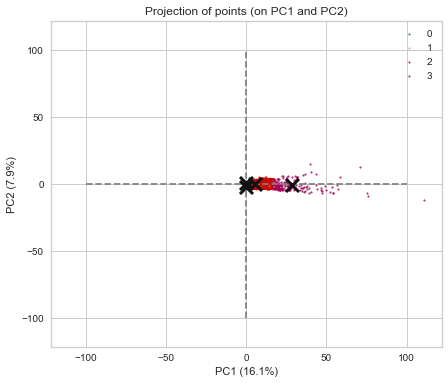

In [143]:
# Affichage
display_factorial_planes2(X_reduced_kmeans_update, 2, pca_kmeans_update,
                         [(0, 1)], illustrative_var=clusters_kmeans_update,
                         alpha=0.8)
plt.scatter(centres_reduced_kmeans_update[:, 0],
            centres_reduced_kmeans_update[:, 1],
            marker='x', s=169, linewidths=3,
            color='k', zorder=10)

In [144]:
# Comparaison du modèle final et amélioré
kmeans_compare = pd.DataFrame(columns=['Modèle',
                                      'Silhouette',
                                      'Davies Bouldin'])

# Affichage des métriques de forme de cluster :
# Silhouette score et Davies Bouldin score
kmeans_compare = calc_metrics('Kmeans final', X_reduced_df_kmeans,
                              kmeans_df_kmeans.labels_, kmeans_compare)

# Affichage des métriques de forme de cluster :
# Silhouette score et Davies Bouldin score
kmeans_compare = calc_metrics('Kmeans amélioré', X_reduced_kmeans_update,
                              kmeans_update.labels_, kmeans_compare)

display(kmeans_compare)

,Modèle,Silhouette,Davies Bouldin
0,Kmeans final,0.708505,0.593954
1,Kmeans amélioré,0.707856,0.591779


## 6. Contrat de maintenance & Ajout de nouveau client <a class="anchor" id="chapter6"></a>

En ce qui concerne le contrat de maintenance, on va suivre l'évolution d'Ajusted Rand Index au fur et à mesure de clients ajoutés par mois. Le modèle de référence sera celui contenant les clients sur l'année 2016. Les différents modèles auxquels on va comparer ce modèle de référence sont les suivants : 2017 + 1 mois, 2017 + 2 mois, 2017 + 3 mois, ...
Le but est d'observer la dégradation de l'ARI et de fixer un seuil à partir duquel il est nécessaire de mettre à jour le modèle. 

In [149]:
# Les données et normalisation des données
cols = df.columns
X_cm = df.copy()
display(X_cm.head())

,order_purchase_timestamp,customer_zip_code_prefix,delivery_delta_days,nb_payment_sequential,sum_payment_installments,is_reviewed,review_score,mean_nb_items,nb_orders,sum_price,...,product_category_books_cds_media,product_category_fashion_clothing_accessories,product_category_flowers_gifts,product_category_groceries_food_drink,product_category_health_beauty,product_category_home_furniture,product_category_other,product_category_sport,product_category_technology,product_category_toys_baby
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,28013,8,1,2,1,5,1.0,1,58.90,...,0,0,1,0,0,0,0,0,0,0
eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06,15775,16,1,3,1,4,1.0,2,252.78,...,0,0,0,0,0,0,1,0,0,0
eb28e67c4c0b83846050ddfb8a35d051,2017-09-18 16:12:04,15775,7,1,1,1,5,1.0,2,252.78,...,0,0,0,0,0,0,0,0,1,0
3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31,35661,8,1,5,1,5,1.0,1,199.00,...,0,0,0,0,0,1,0,0,0,0
af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35,12952,6,1,2,1,4,1.0,1,12.99,...,0,0,0,0,1,0,0,0,0,0


In [155]:
# Calcul des labels
pd.set_option('mode.chained_assignment', 'warn')
df_2016 = X_cm[X_cm['order_purchase_timestamp'].dt.year == 2016]
df_2017 = X_cm[X_cm['order_purchase_timestamp'].dt.year == 2017]
df_2018 = X_cm[X_cm['order_purchase_timestamp'].dt.year == 2018]
#display(df_2018.sort_values('order_purchase_timestamp', ascending=False).head(30))

copie_df = df_2016.copy()
copie_df.drop('order_purchase_timestamp', axis=1, inplace=True)

mat_labels = pd.DataFrame(columns=['Mois', 'Labels'])

# Pour l'année 2017
for i in range(12) :
    standard_scaler = StandardScaler()
    #standard_scaler = MinMaxScaler()
    X_scaled_labels = standard_scaler.fit_transform(copie_df)
    
    pca_label = PCA(n_components=2)
    pca_label.fit(X_scaled_labels)
    X_reduced_labels = pca_label.transform(X_scaled_labels)
    
    kmeans_labels = KMeans(n_clusters=4, init='random',
                          max_iter=300, n_init=10, random_state=42)
    kmeans_labels.fit(X_reduced_labels)
    
    mat_labels = mat_labels.append({'Mois' : i + 1,
                                    'Labels' : kmeans_labels.labels_},
                                    ignore_index=True)
    
    temp_df = df_2017[df_2017['order_purchase_timestamp'].dt.month == i + 1]
    temp_df.drop('order_purchase_timestamp', axis=1, inplace=True)
    
    copie_df = pd.concat([copie_df, temp_df])

# Pour l'année 2018
for i in range(9) :
    standard_scaler2018 = StandardScaler()
    #standard_scaler2018 = MinMaxScaler()
    X_scaled_labels2018 = standard_scaler2018.fit_transform(copie_df)
    
    pca_labels2018 = PCA(n_components=2)
    pca_labels2018.fit(X_scaled_labels2018)
    X_reduced_labels2018 = pca_labels2018.transform(X_scaled_labels2018)
    
    kmeans_labels2018 = KMeans(n_clusters=4, init='random',
                               max_iter=300, n_init=10, random_state=42)
    kmeans_labels2018.fit(X_reduced_labels2018)
    
    mat_labels = mat_labels.append({'Mois' : i + 1,
                                    'Labels' : kmeans_labels2018.labels_},
                                    ignore_index=True)
    
    temp_df = df_2018[df_2018['order_purchase_timestamp'].dt.month == i + 1]
    temp_df.drop('order_purchase_timestamp', axis=1, inplace=True)
    copie_df = pd.concat([copie_df, temp_df])
    
display(mat_labels)

C:\Users\aslic\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\aslic\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\aslic\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\aslic\anaconda3\lib

,Mois,Labels
0,1,"[3, 1, 1, 0, 1, 0, 1, 1, 1, 1, 3, 1, 1, 3, 1, ..."
1,2,"[3, 0, 0, 2, 0, 2, 0, 0, 0, 0, 3, 0, 0, 3, 0, ..."
2,3,"[3, 1, 1, 2, 1, 2, 1, 1, 1, 1, 3, 1, 1, 3, 1, ..."
3,4,"[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, ..."
4,5,"[0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, ..."
5,6,"[3, 1, 1, 2, 1, 2, 1, 1, 1, 1, 3, 1, 1, 3, 1, ..."
6,7,"[2, 0, 0, 3, 0, 3, 0, 0, 0, 0, 2, 0, 0, 2, 0, ..."
7,8,"[1, 2, 2, 0, 2, 0, 2, 2, 2, 2, 1, 2, 2, 1, 2, ..."
8,9,"[2, 3, 3, 0, 3, 0, 3, 3, 3, 3, 2, 3, 3, 2, 3, ..."
9,10,"[1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, ..."


In [156]:
# Calcul ARI pour chaque df
maintenance = pd.DataFrame(columns=['Modèle de référence',
                                    'Evolution + x mois',
                                    'ARI'])

# Modèle de base
df_base = df_2016.copy()
df_base.drop('order_purchase_timestamp', axis=1, inplace=True)

standard_scaler_base = StandardScaler()
#standard_scaler_base = MinMaxScaler()
X_scaled_base = standard_scaler_base.fit_transform(df_base)

pca_base = PCA(n_components=2)
pca_base.fit(X_scaled_base)
X_reduced_base = pca_base.transform(X_scaled_base)

kmeans_base = KMeans(n_clusters=4, init='random',
                     max_iter=300, n_init=10, random_state=42)
kmeans_base.fit(X_reduced_base)

labels_base = kmeans_base.labels_

# Boucle de calcul ARI
for i in range(len(mat_labels)-1) :
    labels_temp = mat_labels.loc[mat_labels.index[i + 1], 'Labels']
    labels_temp = labels_temp[0:labels_base.shape[0]]
    #print(labels_base)
    #print(labels_temp)
    ari_score = metrics.adjusted_rand_score(labels_base, labels_temp)
    
    maintenance = maintenance.append({'Modèle de référence' : 2016, 
                                      'Evolution + x mois' : i+1,
                                      'ARI' : ari_score}, 
                                      ignore_index=True)

display(maintenance)

,Modèle de référence,Evolution + x mois,ARI
0,2016.0,1.0,0.767292
1,2016.0,2.0,0.816800
2,2016.0,3.0,0.608273
3,2016.0,4.0,0.771206
4,2016.0,5.0,0.775522
5,2016.0,6.0,0.741145
6,2016.0,7.0,0.639822
7,2016.0,8.0,0.633539
8,2016.0,9.0,0.604900
9,2016.0,10.0,0.612901


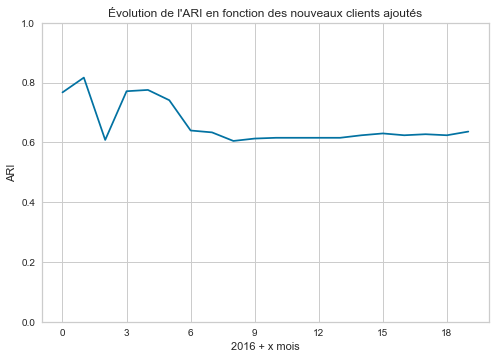

In [157]:
# Affichage
axes = plt.gca()
plt.plot(maintenance['ARI'])
axes.set_ylim([0, 1])
axes.set_title('Évolution de l\'ARI en fonction des nouveaux clients ajoutés')
axes.set_xlabel('2016 + x mois')
axes.set_ylabel('ARI')
axes.xaxis.set_major_locator(MaxNLocator(integer=True))

On observe sur ce graphe que l'ARI commence à se dégrader à partir de + 3 mois. Il est possible de fixer une mise à jour du modèle tous les + 4 mois, ainsi, le contrat de maintenance peut être proposer par trimestre. 

En ce qui concerne l'ajout d'un nouveau client, on peut procéder de plusieurs manières :
- Calculer les distances par raport aux différents centres des clusters et l'affecter le client au cluster avec lequel la distance est minimale.
- Entrainer un modèle labélisé grâce aux résultats obtenus pour affecter le client à un cluster.
- Appliquer kmeans sur l'ensemble des clients avec le nouveau clients.

In [173]:
# Calcul de la distance euclienne du nouveau client pour l'affecter à un cluster
nouveau_client = df_2017.head(1)
nouveau_client.drop('order_purchase_timestamp', axis=1, inplace=True)

# Normalisation nouveau client
scaled_nouveau_client = ms_df_kmeans.fit_transform(nouveau_client)

# PCA nouveau client
reduced_nouveau_client = pca_df_kmeans.transform(scaled_nouveau_client)

# Calcul de distances par rapport aux centres de clusters
mat_distance = pd.DataFrame(columns=['Cluster', 'Distance'])
for i in range(len(centres_reduced_df_kmeans)):
    temp_dist = math.dist(centres_reduced_df_kmeans[i], reduced_nouveau_client[0])
    mat_distance = mat_distance.append({'Cluster' : i, 
                                        'Distance' : temp_dist}, 
                                        ignore_index=True)
display(mat_distance)

C:\Users\aslic\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Cluster,Distance
0,0.0,0.844623
1,1.0,5.152250
2,2.0,2.454113
3,3.0,28.204639


In [174]:
# Enregistrer la session notebook
dill.dump_session('notebook_env_0809_entier.db')